# Basic approach for measurement uncertainty evalaution
First name: principle modelling (PM)

## Contribution to CIE2023 in Ljubljana

# Modelling

## wavelength scale
$\mathbf{\lambda}^\mathrm{r}=k_{\mathrm{\lambda\ m-c}}\bullet\left(\mathbf{\lambda}+\lambda_{\mathrm{a-c}}+\mathbf{\lambda}_{\mathrm{a-uc}}+\mathbf{\lambda}_{\mathrm{a-b}}\right)$

## value scale
$\mathbf{S}^\mathrm{r}=\mathbf{S}\bullet \mathbf{k}_{\mathrm{Sm-f}}\bullet \left(1+S_{\mathrm{a-c}}+\mathbf{S}_{\mathrm{a-uc}}+\mathbf{S}_{\mathrm{a-b}}\right)$

Remark:
The different modelling of the scales it due to the usual way of using the uncertainty contributions only.
In the wavelength scale we use absolute uncertainties every time, whereas in the value scale we use relative once. Therefore, the modelling is made a little bit different.

In [1]:
from scipy import rand

# temp import only
from empir19nrm02.tools.help import strd, label_font_size, plot_cmf2, save_fig, get_target, label_management, \
    quantil, display_responsivity

#%run -i jhelp


import luxpy as lx
import numpy as np
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression

from empir19nrm02.f1prime import py_f1PrimeGlx
from empir19nrm02.tools import plotCorrMatrixSmall
%matplotlib inline
from empir19nrm02.tools.help import plotCorrelation
from empir19nrm02.tools import plotHistScales, plotHistGauss, plot_2D, seaborn_plot_result_gen
from empir19nrm02.MC import DistributionParam, MCVar, MCSimulation, NameUnit, MCVectorVar, load_from_csv, load_from_excel, StatDataVector
from empir19nrm02 import _SPD, _RES
import pandas as pd
import matplotlib.ticker as ticker
import luxpy as lx
import time

out_dir = 'MCSim_PM'

# comma or point as decimal separator (True--> CIE, False-->LRT)
use_comma = True
if use_comma:
    dec_sep = ','
else:
    dec_sep = '.'

NumberTrials = 10000
# Number of base functions (as a hack with pos/neg number of base functions to select the type...)
# >0 use sin/cos base functions
# <0 use chebyshev base functions
N_Fourier = 'c 7'
N_Fourier1 = 'f 7'
N_Fourier2 = 'f 7 s'
maxOutElements = 5
lambda0 = 555

# Number of base functions
highRes = 1
if highRes == 0:
    wl = lx.getwlr([360,830,5])
    len_wl = len(wl)
    elements2Run = [-1, 0,1,2,3,4,5,6,7,8,9,10,20,30,int(len_wl/2)]
else:
    wl = lx.getwlr([360,830,1])
    len_wl = len(wl)
    # new elements2Run (see logscale.xlsx for a linear distribution of values in a log scale format)
    elements2Run = [-1, 0,1,2,3,4,5,6,7,8,9,10,11,12,15,19,24,30,38,48,60,75,95,119,149,187,235]
print( elements2Run)

# distribution temperature for the blackBody
T0 = 3077

# peak_wavelength for the LED modelling
led_peak = 555
led_bandwidth = 20

import os
print( 'CWD:', os.getcwd())

marker = ['-', '--', '-.',':', '.', 'o', '-', '--','-.',':','.']
point_marker = ['x', 'o', 'v', '^']
mColor = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'r', 'g', 'b', 'c']

if use_comma:
    #Locale settings
    import locale
    # Set to German locale to get comma decimal separater
    locale.setlocale(locale.LC_NUMERIC, "de_DE")

[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 19, 24, 30, 38, 48, 60, 75, 95, 119, 149, 187, 235]
CWD: E:\TTBV\Python\empir19nrm02\empir19nrm02\Jupyter


In [2]:
# Benutzerdefinierter Stil definieren
plot_style = {
    'axes.spines.top': True,
    'axes.spines.bottom': True,
    'axes.spines.left': True,
    'axes.spines.right': True,
    'axes.linewidth': 1,
    'axes.edgecolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'xtick.major.width': 1,
    'ytick.major.width': 1,
    'xtick.major.size': 2,
    'ytick.major.size': 2,
    'axes.grid': False,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.bottom': True,
    'ytick.left': True,
}

# Stil aktivieren
pyplot.style.use(plot_style)
if use_comma:
    # Tell matplotlib to use the locale we set above
    pyplot.rcParams['axes.formatter.use_locale'] = True

In [3]:
def custom_decimal(value_str):
    # Split the string into integer and decimal parts
    integer_part, decimal_part = value_str.split('.')
    # Add spaces after every third character in the integer part
    decimal_part_formatted = " ".join([decimal_part[i:i+3] for i in range(0, len(decimal_part), 3)])
    # Join the formatted integer part with the decimal part and return the result
    formatted_value = integer_part + dec_sep + decimal_part_formatted

    return formatted_value

def custom_color(x,pos):
    value_str = f"{x:,.{4}f}"
    return custom_decimal(value_str)
def custom_color1(x,pos):
    value_str = f"{x:,.{5}f}"
    return custom_decimal(value_str)

def custom_formatter(x, pos):
    # Convert the float to a string
    value_str = f"{x:,.{0}f}"

    # Split the string into integer and decimal parts
    integer_part, decimal_part = value_str.split('.')

    # Add spaces after every third character in the integer part
    decimal_part_formatted = " ".join([decimal_part[i:i+3] for i in range(0, len(decimal_part), 3)])
    # Add spaces after every third character in the integer part
    #integer_part_formatted = integer_part.replace(",", " ")
    integer_part_formatted = integer_part
    #integer_part_formatted = " ".join([integer_part[i:i+3] for i in range(0, len(integer_part), 3)])

    # Join the formatted integer part with the decimal part and return the result
    formatted_value = integer_part_formatted + dec_sep + decimal_part_formatted

    return formatted_value

### Draw some reference curves for the article

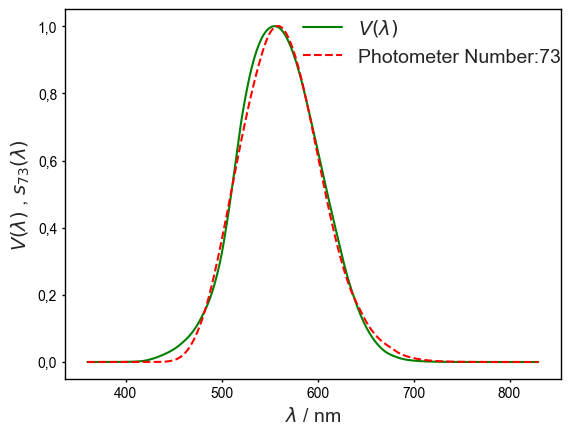

In [4]:
selected_Detector = 73
_detectors=_RES['VLDetectors']['S']['data'].copy()

_detectors_i = lx.cie_interp(_detectors, wl_new=wl, kind='S')
s_target = _detectors_i[1]
currentDetector = _detectors_i[selected_Detector]

fig0, ax0 = pyplot.subplots()

ax0.plot(wl, _detectors_i[1],'g-', label=strd['VLambda'])
ax0.plot(wl, _detectors_i[selected_Detector],'r--', label=r'Photometer Number:' + str(selected_Detector))
ax0.set_xlabel('$\lambda$ / nm',fontsize=label_font_size)
ax0.set_ylabel(strd['VLambda'] + r' , $s_{' + str(selected_Detector) + '}(\lambda)$',fontsize=label_font_size)
fig0.legend(bbox_to_anchor=(0.47, 0.6, 0.4, 0.3), loc='upper left', frameon=False,fontsize=label_font_size)

save_fig(out_dir, filename='SampleDetectorSPD')


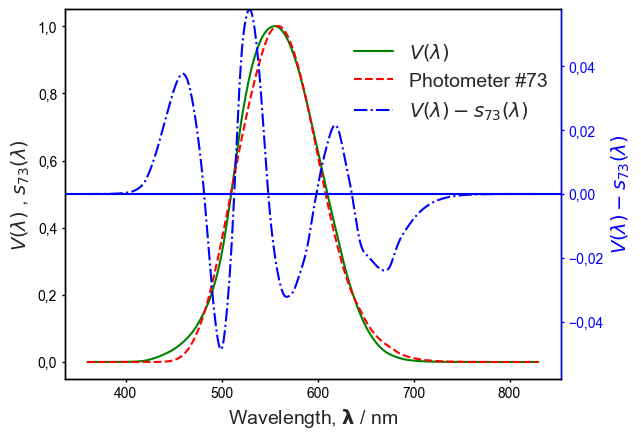

In [5]:
strNumberDetector = str(selected_Detector)

x_label = 'Wavelength, $\mathbf{\lambda}$ / nm'
y_label = 'Signal $\mathbf{S}$ / A.U.'

fig0, ax0 = pyplot.subplots()
strNumber = str(selected_Detector)
ax0.plot(wl, s_target,'g-', label=strd['VLambda'])
ax0.plot(wl, _detectors_i[selected_Detector],'r--', label=r'Photometer #' + strNumber)
ax0.set_ylabel(strd['VLambda'] + r' , $s_{' + strNumber + '}(\lambda)'+ '' +'$',fontsize=label_font_size)
ax0.set_xlabel(x_label,fontsize=label_font_size)


strDiff = '$V(\lambda)-s_{' + strNumberDetector + '}(\lambda)$'
ax1 = ax0.twinx()

f = np.sum(s_target)/np.sum(_detectors_i[selected_Detector])
diff_detector = s_target-f*_detectors_i[selected_Detector]
ax1.plot(wl, diff_detector, 'b-.', label=strDiff)
ax1.set_ylabel( strDiff,fontsize=label_font_size)

ax1.set_ylim((-np.max(np.abs(diff_detector)), np.max(np.abs(diff_detector))))
ax1.axhline(0, color = 'blue')


[lines, labels]=label_management( fig0, ax1, 'blue')
fig0.legend(lines, labels, bbox_to_anchor=(0.55, 0.55, 0.4, 0.3), loc='upper left',frameon=False,fontsize=label_font_size)


save_fig(out_dir, filename='SampleDetectorAbsDiff')

In [6]:
def plotMCResult( wl, mcVarData:StatDataVector, title=None, fig = None, ax1 = None, ax2 = None, diagnumber=0):
    bFirst = False
    if not fig:
        fig, ax1 = pyplot.subplots()
        ax2 = ax1.twinx()
        color1 = 'r-'
        color2 = 'g:'
    else:
        if diagnumber == 1:
            color1 = 'r-'
            color2 = 'g:'
        else:
            color1 = 'r--'
            color2 = 'g-.'

    if not title:
        title = ''
    ax1.plot(wl, mcVarData.v_mean/np.max(mcVarData.v_mean), color1, label= title + ' $S_{\mathrm{rel}}(\lambda)$')
    ax2.plot(wl,mcVarData.v_std / mcVarData.v_mean, color2, label= title + ' $u_{\mathrm{rel}}(S_{\mathrm{rel}})(\lambda)$')
    ax1.set_xlabel(x_label,fontsize=label_font_size)
    ax1.set_ylabel(y_label, color = 'red',fontsize=label_font_size)
    ax2.set_ylabel('$\sigma_{\mathrm{rel}}$', color = 'green',fontsize=label_font_size)
    if title:
        ax1.set_title(title)
    ax2.yaxis.set_major_formatter(ticker.FuncFormatter(custom_color))
    fig.legend(bbox_to_anchor=(.6,.6), loc="upper left", frameon=False, fontsize=label_font_size)
    return fig, ax1, ax2

FEL integral data: CCT: [[3.0777e+03]] K, Duv: [[2.0527e-04]]


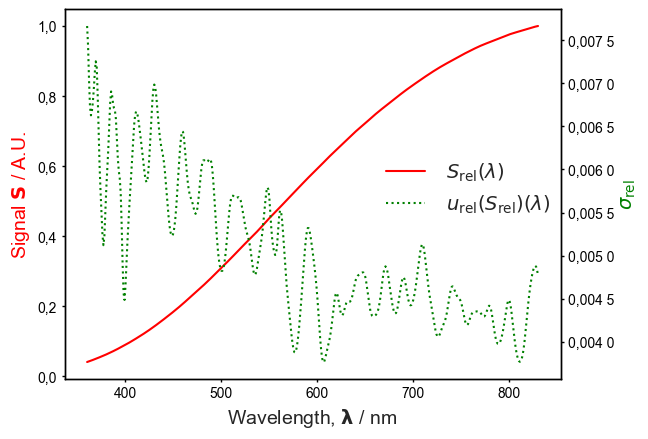

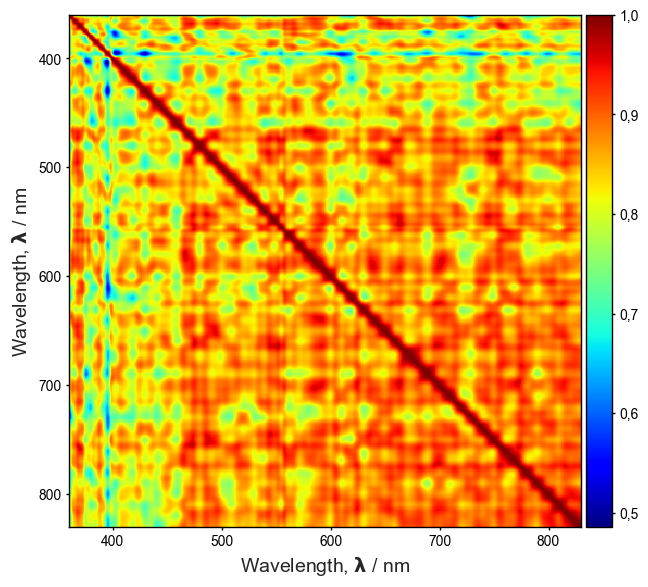

In [7]:
from empir19nrm02.spectral.spectral_data import _CORR_PATH
from glob import glob

file_list = glob(_CORR_PATH + "PTBResFEL-1000W-Lamp-1.csv", recursive = False)
for file in file_list:
    if 'xls' in file:
        wlFEL, mcVectorVarFEL = load_from_excel(filename= file, wlColumn = 1, valColumn=2, stdColumn = 3, covColumn=None, corrColumn = 4, startRow=2)
    else:
        wlFEL, mcVectorVarFEL = load_from_csv(filename= file)
        XYZ_FEL = lx.spd_to_xyz(np.vstack((wlFEL, mcVectorVarFEL.setData.v_mean)), relative=False)
        CCT_FEL, duv_FEL = lx.xyz_to_cct(XYZ_FEL, out = 'cct,duv')
        print( f"FEL integral data: CCT: {CCT_FEL} K, Duv: {duv_FEL}")
    mcVectorVarFEL.interpolate(wl, wlFEL, trials=NumberTrials)
    file_base = os.path.basename(file)
    fig, ax1, ax2 = plotMCResult(wl, mcVectorVarFEL.setData)
    save_fig(out_dir, filename='FEL')
    #fig.legend(bbox_to_anchor=(1,1), loc="upper left")
    plotCorrelation(mcVectorVarFEL.setData.corr_matrix, wl, '', x_label=x_label, y_label=x_label)
    save_fig(out_dir, filename='CorrFEL')

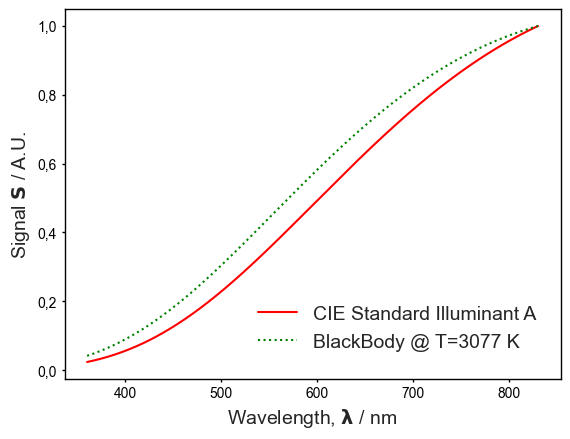

In [8]:
spectra=_SPD['PHOTOLED']['S']['data'].copy()

fig0, ax0 = pyplot.subplots()
spectra_i = lx.cie_interp(spectra, wl_new=wl, kind='S')
bb_T0 = lx.blackbody(T0, wl, relative=False)
ax0.plot(wl, spectra_i[1]/np.max(spectra_i[1]), 'r-', label=r'CIE Standard Illuminant A')
ax0.plot(wl, bb_T0[1]/np.max(bb_T0[1]), 'g:', label=r'BlackBody @ T=' + str(T0) + ' K')
#ax0.plot(wl,mcVectorVarFEL.setData.v_mean/np.max(mcVectorVarFEL.setData.v_mean), 'bx', label=r'FEL')
ax0.set_ylabel( y_label,fontsize=label_font_size)
ax0.set_xlabel( x_label,fontsize=label_font_size)

fig0.legend(bbox_to_anchor=(0.4, 0.05, 0.4, 0.25), loc='upper left', frameon=False,fontsize=label_font_size)

save_fig(out_dir, filename='SampleSD')

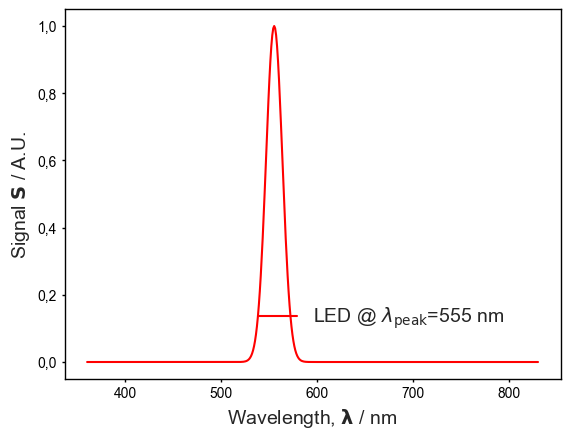

In [9]:
fig0, ax0 = pyplot.subplots()
led = lx.toolboxes.spdbuild.gaussian_spd( \
        peakwl=led_peak, fwhm=led_bandwidth, wl=wl, with_wl=False)

ax0.plot(wl, led[0]/np.max(led[0]), 'r-', label=r'LED @ $\lambda_{\mathrm{peak}}$=' + str(led_peak) + ' nm')
ax0.set_ylabel( y_label,fontsize=label_font_size)
ax0.set_xlabel( x_label,fontsize=label_font_size)

fig0.legend(bbox_to_anchor=(0.4, 0.05, 0.4, 0.25), loc='upper left', frameon=False,fontsize=label_font_size)

save_fig(out_dir, filename='SampleLED')

# Show the basis function approach

0.0
1.0
1.0000000000000002
1.0


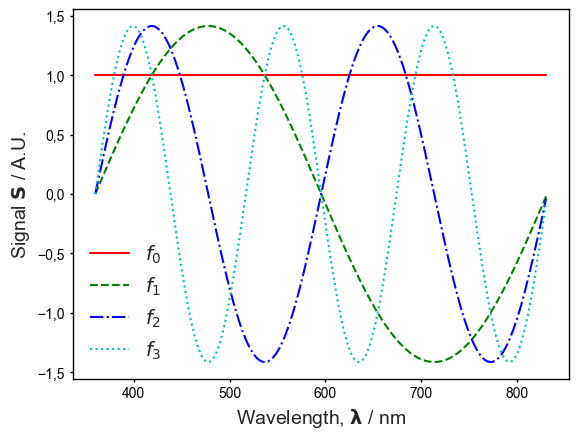

0.0
1.0
1.0
0.9999999999999999


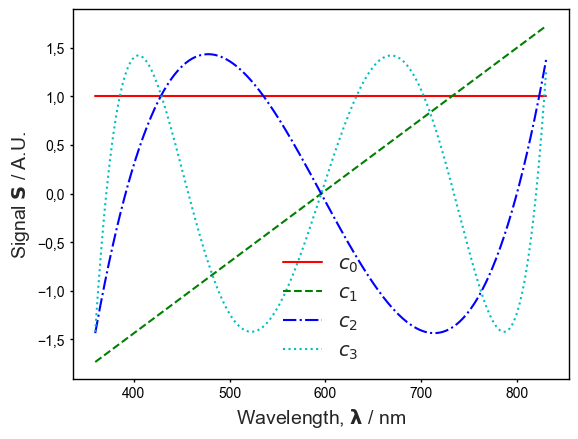

0.0
0.9952485145225569
0.7277204282462879
0.8158869818859591


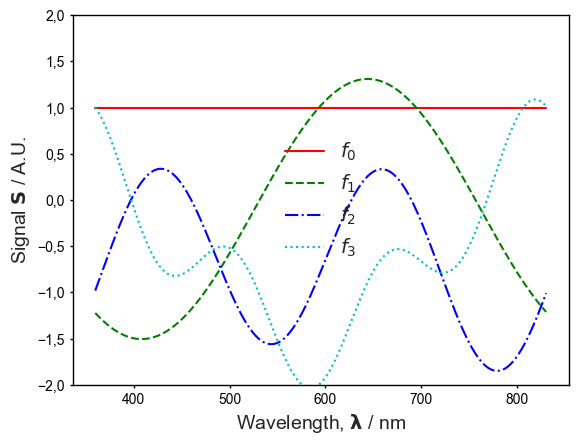

0.0
0.9976324356324041
0.8141947005764578
0.9976255106486063


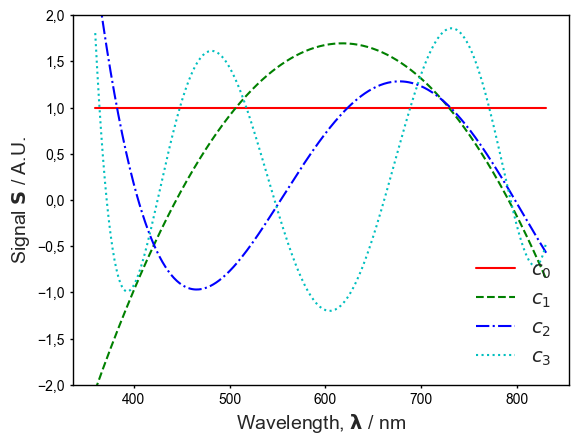

In [10]:
from empir19nrm02.MC import  generate_base_functions

base_function_steps = len(wl)

def plot_base_functions( mode, mode2):
    for number_base in range(4):
        baseFunctions = generate_base_functions(mode + ' '  + str(number_base)+ ' ' + mode2, base_function_steps, 1)
        if 'f' in mode:
            pyplot.plot( wl, baseFunctions, mColor[number_base]+marker[number_base], label=r'$f_{' + str(number_base) + '}$')
        else:
            pyplot.plot( wl, baseFunctions, mColor[number_base]+marker[number_base], label=r'$c_{' + str(number_base) + '}$')

        print( np.std(baseFunctions))

    pyplot.xlabel(x_label, size=label_font_size)
    pyplot.ylabel(y_label, size=label_font_size)
    pyplot.legend(frameon=False,fontsize=label_font_size)

plot_base_functions('f', 'o s ng')
save_fig(out_dir, 'base_functions_f')
plot_base_functions('c', 'o s ng')
save_fig(out_dir, 'base_functions_c')

plot_base_functions('f', 'o')
pyplot.ylim([-2,2])
save_fig(out_dir, 'base_functions_fr')
plot_base_functions('c', 'o')
pyplot.ylim([-2,2])
save_fig(out_dir, 'base_functions_cr')

# Make some very first MCS

In [11]:
# define some input data (as MCVar to make an analysis after the run)

# Change of the BB Temperature
mcT = MCVar(name=NameUnit('T', 'K'), distribution=DistributionParam(mean=T0,stddev=1., distribution='normal'))

mcLED = MCVar(name=NameUnit('led_peak', 'nm'), distribution=DistributionParam(mean=led_peak,stddev=1., distribution='normal'))

# wavelength

# Correlated noise (once for every trial)
mcLambda_a_c = MCVar(name=NameUnit('$\lambda_\mathrm{a-c}$', 'nm'), distribution=DistributionParam(mean=0.,stddev=1., distribution='normal'))

# uncorrelated noise (once for every trial and every wavelength position)
mcLambda_a_uc = MCVectorVar(name=NameUnit('$\lambda_\mathrm{a-uc}$', 'nm'), elements=len(wl))
mcLambda_a_uc.set_vector_param( np.zeros(len(wl)), np.ones(len(wl)))

# base function noise (one selected setting only)
mcLambda_a_f = MCVectorVar(name=NameUnit('$\lambda_\mathrm{a-b}$', 'nm'), elements=len(wl), noise_list={ 'f_add': DistributionParam(mean = 0, stddev = 1, distribution = 'normal', add_params = N_Fourier)})
mcLambda_a_f.set_vector_param( np.zeros(len(wl)), np.ones(len(wl)))

# correlated factor for the wavelength calibration (attention 0.1% only)
mcLambda_m_c = MCVar(name=NameUnit('$k_{\lambda\mathrm{m-c}}$', '1'), distribution=DistributionParam(mean=1.,stddev=0.001, distribution='normal'))

# Signal
mcS_a_c = MCVar(name=NameUnit('$S_\mathrm{a-c}$', ''), distribution=DistributionParam(mean=0.,stddev=0.01, distribution='normal'))

mcS_a_uc = MCVectorVar(name=NameUnit('$S_\mathrm{a-uc}$', ''), elements=len(wl))
mcS_a_uc.set_vector_param( np.zeros(len(wl)), 0.01*np.ones(len(wl)))

mcS_a_f = MCVectorVar(name=NameUnit('$S_\mathrm{a-b}$', ''), elements=len(wl), noise_list={ 'f_add': DistributionParam(mean = 0, stddev = 0.01, distribution = 'normal', add_params = N_Fourier)})
mcS_a_f.set_vector_param( np.zeros(len(wl)), 0.01*np.ones(len(wl)))

mcS_m_f = MCVectorVar(name=NameUnit('$k_\mathrm{Sm-b}$', ''), elements=len(wl), noise_list={ 'f_mul': DistributionParam(mean = 0, stddev = 0.01, distribution = 'normal', add_params = N_Fourier)})
mcS_m_f.set_vector_param( np.ones(len(wl)), 0.01*np.ones(len(wl)))

mcS_m_f1 = MCVectorVar(name=NameUnit('$k_\mathrm{Sm-b}$', ''), elements=len(wl), noise_list={ 'f_mul': DistributionParam(mean = 0, stddev = 0.01, distribution = 'normal', add_params = N_Fourier1)})
mcS_m_f1.set_vector_param( np.ones(len(wl)), 0.01*np.ones(len(wl)))

mcS_m_f2 = MCVectorVar(name=NameUnit('$k_\mathrm{Sm-b}$', ''), elements=len(wl), noise_list={ 'f_mul': DistributionParam(mean = 0, stddev = 0.01, distribution = 'normal', add_params = N_Fourier2)})
mcS_m_f2.set_vector_param( np.ones(len(wl)), 0.01*np.ones(len(wl)))


# define some output data (as MCVar to make an analysis after the run)
mcYxy = MCVectorVar(name=NameUnit(['L','x','y'], ['','','']), elements=3)
mcCCT = MCVar(name=NameUnit('CCT', 'K'))
mclpeak = MCVar(name=NameUnit('lpeak', 'nm'))
mcDuv = MCVar(name=NameUnit('Duv', ''))
mcSMCF = MCVar(name=NameUnit('F', ''))
mcSpectrum = MCVectorVar(name=NameUnit('L', ''), elements=len(wl))

# define some basic data needed inside the MCS
kBB = 1./(lx.spd_to_xyz(lx.blackbody(T0, wl, relative=False))[0][1])

# helpwise the delta lambda values for the integration
dl = lx.getwld(wl) # wavelength differences (unequal wavelength spacings are taken into account)
dl = dl*np.ones_like(wl) # ensure array like for matrix multiplication

def runSimpleMC( input, output, NumberTrials, model_function):
    sim = MCSimulation(trials=NumberTrials)
    sim.set_input_var(input)
    sim.set_output_var(output)
    sim.generate()
    sim.calculate_model( model_function)
    return sim.output_var, sim.get_result_db()

# simple model calculating the photometric integrals
def model_L0( T, Lambda_a_c, Lambda_a_uc, Lambda_a_f, Lambda_m_c, S_a_c, S_a_uc, S_a_f, S_m_f):
    #wl_in = (1. + Lambda_a_c + Lambda_a_uc + Lambda_a_f)
    wl_mod = Lambda_m_c*(wl + Lambda_a_c + Lambda_a_uc + Lambda_a_f)
    # using the manipulated wl-scale for calculation of the bb
    bb = lx.blackbody(T, wl_mod, relative=False)
    # reconstruct the nominal one
    bb_mod = bb.copy()
    bb_mod[0] = wl
    bb_mod[1] *= kBB
    bb_mod[1] = bb_mod[1]*S_m_f*(1. + S_a_c + S_a_uc + S_a_f)
    XYZ = lx.spd_to_xyz(bb_mod, relative=False)
    Yxy = lx.xyz_to_Yxy(XYZ)
    CCT, duv = lx.xyz_to_cct(XYZ, out = 'cct,duv')
    #SMCF = (bb_mod[1] @ (s_target*dl).T) / (bb_mod[1] @ (currentDetector*dl).T)
    SMCF=lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors(bb_mod, np.vstack((wl, currentDetector)), S_C='A')[0]

    return [Yxy[0], CCT, SMCF, bb_mod[1]]

# simple model calculating the photometric integrals
def model_LED( lPeak, Lambda_a_c, Lambda_a_uc, Lambda_a_f, Lambda_m_c, S_a_c, S_a_uc, S_a_f, S_m_f):
    wl_mod = Lambda_m_c*(wl + Lambda_a_c + Lambda_a_uc + Lambda_a_f)

    # using the manipulated wl-scale for calculation of the LED
    led = lx.toolboxes.spdbuild.gaussian_spd( \
        peakwl=lPeak, fwhm=led_bandwidth, wl=wl_mod, with_wl=True)
    # reconstruct the nominal one
    led_mod = led.copy()
    led_mod[0] = wl
    led_mod[1] *= 1
    led_mod[1] = led_mod[1]*S_m_f*(1. + S_a_c + S_a_uc + S_a_f)
    XYZ = lx.spd_to_xyz(led_mod, relative=False)
    Yxy = lx.xyz_to_Yxy(XYZ)
    lPeakRes = lx.detect_peakwl(led_mod, verbosity=0)[0]['peaks']
    #SMCF = (bb_mod[1] @ (s_target*dl).T) / (bb_mod[1] @ (currentDetector*dl).T)
    SMCF=lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors(led_mod, np.vstack((wl, currentDetector)), S_C='A')[0]

    return [Yxy[0], lPeakRes, SMCF, led_mod[1]]

# simple model calculating the photometric integrals from a FEL Lamp
def model_FEL( inFEL):
    specFEL = np.vstack((wl, inFEL))
    XYZ = lx.spd_to_xyz(specFEL, relative=False)
    Yxy = lx.xyz_to_Yxy(XYZ)
    CCT, duv = lx.xyz_to_cct(XYZ, out = 'cct,duv')
    SMCF=lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors(specFEL, np.vstack((wl, currentDetector)), S_C='A')[0]

    return [Yxy[0], CCT, SMCF, inFEL]

input = [mcT, mcLambda_a_c, mcLambda_a_uc, mcLambda_a_f, mcLambda_m_c, mcS_a_c, mcS_a_uc, mcS_a_f, mcS_m_f]
input_len = len(input)
output = [mcYxy, mcCCT, mcSMCF, mcSpectrum]

startMC = time.time()
mcResult, res_data = runSimpleMC(input, output, NumberTrials, model_L0)
endMC = time.time()

estTime = 4*len(elements2Run)*(endMC-startMC)
print(f"Estimated full running time for 4 times {len(elements2Run)} simulations: {estTime} s --> {estTime/3600} h")


res_data.to_csv(out_dir + '/table1.csv', sep=';', decimal=',')
res_data


Estimated full running time for 4 times 27 simulations: 5830.49148273468 s --> 1.6195809674263 h


Input Unit           Mean     StdDev       Distr   
0                          T    K 3,077.00000000 1.00000000      normal  \
0     $\lambda_\mathrm{a-c}$   nm     0.00000000 1.00000000      normal   
0    $\lambda_\mathrm{a-uc}$   nm     0.00000000 1.00000000      normal   
0     $\lambda_\mathrm{a-b}$   nm     0.00000000 1.00000000  normal c 7   
0  $k_{\lambda\mathrm{m-c}}$    1     1.00000000 0.00100000      normal   
0           $S_\mathrm{a-c}$          0.00000000 0.01000000      normal   
0          $S_\mathrm{a-uc}$          0.00000000 0.01000000      normal   
0           $S_\mathrm{a-b}$          0.00000000 0.01000000  normal c 7   
0          $k_\mathrm{Sm-b}$          0.00000000 0.01000000  normal c 7   
0                        All          0.00000000 0.00000000               

           L       u(L)          x       u(x)          y       u(y)   
0 1.00001522 0.00267891 0.43155459 0.00006858 0.40215529 0.00002540  \
0 0.99993980 0.00576842 0.43156196 0.00055814 0.40215788 0.00025420   
0 0.99999331 0.00048452 0.43155305 0.00009962 0.40215317 0.00011589   
0 0.99985081 0.00657801 0.43157016 0.00084739 0.40216217 0.00077947   
0 1.00000414 0.00324855 0.43155476 0.00021139 0.40215525 0.00007830   
0 1.00011302 0.01002182 0.43155489 0.00000000 0.40215541 0.00000000   
0 1.00000985 0.00083660 0.43155347 0.00014592 0.40215680 0.00013729   
0 0.99988293 0.01145590 0.43154933 0.00097012 0.40215802 0.00087982   
0 1.00009321 0.01141527 0.43156443 0.00098098 0.40213984 0.00088178   
0 0.99990346 0.02142833 0.43157715 0.00173479 0.40215048 0.00152253   

             CCT      u(CCT)          F       u(F)  
0 3,077.00466039  0.99994454 1.00240358 0.00001000  
0 3,076.91774626  7.74720953 1.00240257 0.00007416  
0 3,077.01438576  1.72928269 1.00240374 0.00002344  
0 3,076.82880258 13.89382264 1.00240100 0.00010652  
0 3,077.00420889  3.08207389 1.00240354 0.00003083  
0 3,077.00000000  0.00000000 1.00240353 0.00000000  
0 3,077.03751744  2.98008733 1.00240307 0.00003784  
0 3,077.17340893 19.76481291 1.00240554 0.00014886  
0 3,076.75920722 20.02961377 1.00240404 0.00015026  
0 3,076.74495559 32.64014069 1.00240237 0.00025495

In [12]:
inputFEL = [mcVectorVarFEL]
input_len = len(input)
output = [mcYxy, mcCCT, mcSMCF, mcSpectrum]
mcResultFEL, res_dataFEL = runSimpleMC(inputFEL, output, NumberTrials, model_FEL)

res_dataFEL.to_csv(out_dir + '/table1FEL.csv', sep=';', decimal=',')
res_dataFEL


Input    Unit       Mean     StdDev   Distr          L       u(L)   
0  Input#0  Unit#0 0.05002378 0.00022769  normal 1.00003364 0.00452915  \
0      All         0.00000000 0.00000000         1.00003364 0.00452915   

           x       u(x)          y       u(y)            CCT     u(CCT)   
0 0.43182789 0.00015899 0.40253886 0.00009668 3,075.34679452 2.90992582  \
0 0.43182789 0.00015899 0.40253886 0.00009668 3,075.34679452 2.90992582   

           F       u(F)  
0 1.00242239 0.00001852  
0 1.00242239 0.00001852

In [13]:
inputLED = [mcLED, mcLambda_a_c, mcLambda_a_uc, mcLambda_a_f, mcLambda_m_c, mcS_a_c, mcS_a_uc, mcS_a_f, mcS_m_f]
input_len = len(input)
output = [mcYxy, mclpeak, mcSMCF, mcSpectrum]
mcResultLED, res_dataLED = runSimpleMC(inputLED, output, NumberTrials, model_LED)

res_dataLED.to_csv(out_dir + '/table1LED.csv', sep=';', decimal=',')
res_dataLED

Input Unit         Mean     StdDev       Distr   
0                   led_peak   nm 555.00000000 1.00000000      normal  \
0     $\lambda_\mathrm{a-c}$   nm   0.00000000 1.00000000      normal   
0    $\lambda_\mathrm{a-uc}$   nm   0.00000000 1.00000000      normal   
0     $\lambda_\mathrm{a-b}$   nm   0.00000000 1.00000000  normal c 7   
0  $k_{\lambda\mathrm{m-c}}$    1   1.00000000 0.00100000      normal   
0           $S_\mathrm{a-c}$        0.00000000 0.01000000      normal   
0          $S_\mathrm{a-uc}$        0.00000000 0.01000000      normal   
0           $S_\mathrm{a-b}$        0.00000000 0.01000000  normal c 7   
0          $k_\mathrm{Sm-b}$        0.00000000 0.01000000  normal c 7   
0                        All        0.00000000 0.00000000               

           L       u(L)          x       u(x)          y       u(y)   
0 0.99978695 0.00030247 0.34237991 0.00696303 0.65264196 0.00651895  \
0 0.99978631 0.00030549 0.34236031 0.00697496 0.65266024 0.00653003   
0 0.99984626 0.01491018 0.34243204 0.00112396 0.65259316 0.00105820   
0 0.99972393 0.03040470 0.34241331 0.00903763 0.65259436 0.00846640   
0 0.99992558 0.00094811 0.34233409 0.00385684 0.65269963 0.00361424   
0 1.00007373 0.01004140 0.34237407 0.00000000 0.65266849 0.00000000   
0 0.99998381 0.00180850 0.34237430 0.00007782 0.65266822 0.00007364   
0 0.99983001 0.01357964 0.34237112 0.00015763 0.65267124 0.00014794   
0 1.00004327 0.01343876 0.34237424 0.00015859 0.65266832 0.00014885   
0 0.99898531 0.04063091 0.34242500 0.01387807 0.65251448 0.01298579   

         lpeak   u(lpeak)          F       u(F)  
0 555.00130000 1.03271405 1.00329624 0.00217202  
0 554.99950000 1.03783416 1.00330260 0.00217603  
0 554.99670000 1.03725075 1.00329684 0.00037447  
0 555.00660000 1.40198304 1.00334360 0.00284431  
0 554.99360000 0.61396990 1.00326072 0.00119076  
0 555.00000000 0.00000000 1.00322633 0.00000000  
0 554.99780000 0.68992402 1.00322641 0.00002644  
0 555.00000000 0.00000000 1.00322727 0.00004893  
0 555.00000000 0.00000000 1.00322630 0.00004920  
0 554.99950000 2.36273142 1.00358749 0.00434992

In [14]:
def get_name(i:int)->str:
    return res_data['Input'].values[i]

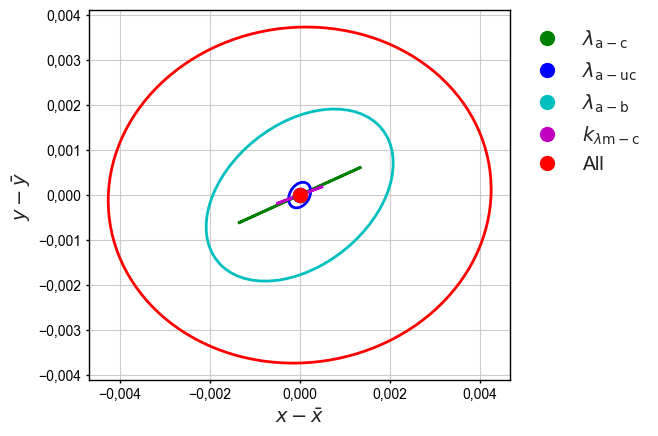

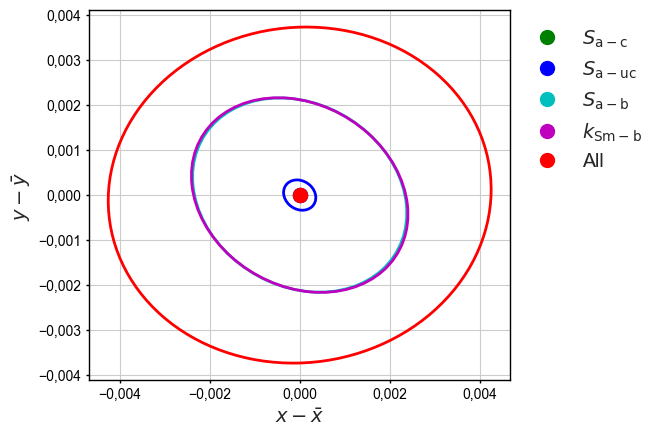

In [15]:
ax = None
len_part1 = 5
index_end = input_len

for i in [*range(1, len_part1), index_end]:
    var = mcResult[i]
    if i == index_end:
        ax = plot_2D(var[0], offset=1, center_data=True, marker_color=mColor[0], ax1=ax, name=get_name(i), number=0)
    else:
        ax = plot_2D(var[0], offset=1, center_data=True, marker_color=mColor[i], ax1=ax, name=get_name(i), number=0)

pyplot.legend(bbox_to_anchor=(1,1), loc="upper left",frameon=False,fontsize=label_font_size)
save_fig(out_dir, 'xy_lambda_all')

ax = None
for i in range(len_part1, input_len+1):
    var = mcResult[i]
    if i == index_end:
        ax = plot_2D(var[0], offset=1, center_data=True, marker_color=mColor[0], ax1=ax, name=get_name(i), number=0)
    else:
        ax = plot_2D(var[0], offset=1, center_data=True, marker_color=mColor[i-len_part1+1], ax1=ax, name=get_name(i), number=0)

pyplot.legend(bbox_to_anchor=(1,1), loc="upper left", frameon=False,fontsize=label_font_size)
save_fig(out_dir, 'xy_S_all')

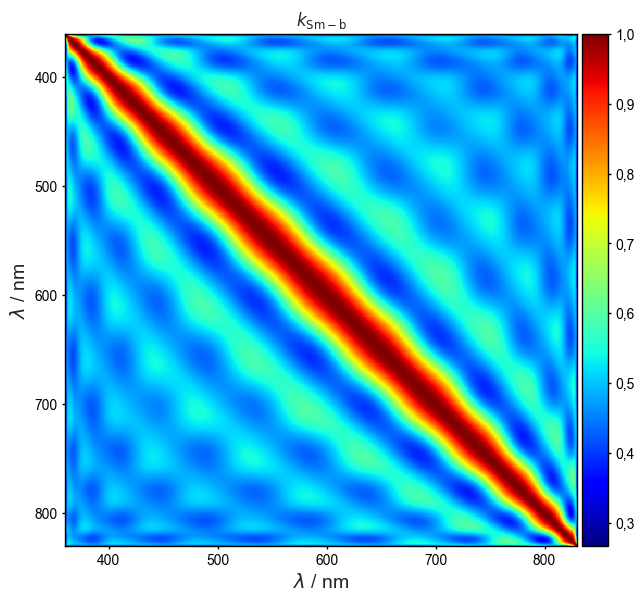

In [16]:
def corrDiag(mcResult_loc, diag_number, desc_offset):
    var = mcResult_loc[diag_number]
    var[-1].calc_cov_matrix_from_data()
    plotCorrelation(var[-1].runData.corr_matrix, wl, get_name(diag_number))
    save_fig(out_dir, 'DataCorr_' + str(desc_offset) + '_' + str(diag_number))

for i in range(input_len+1):
    if i == 8:
        corrDiag(mcResult, i, 0)

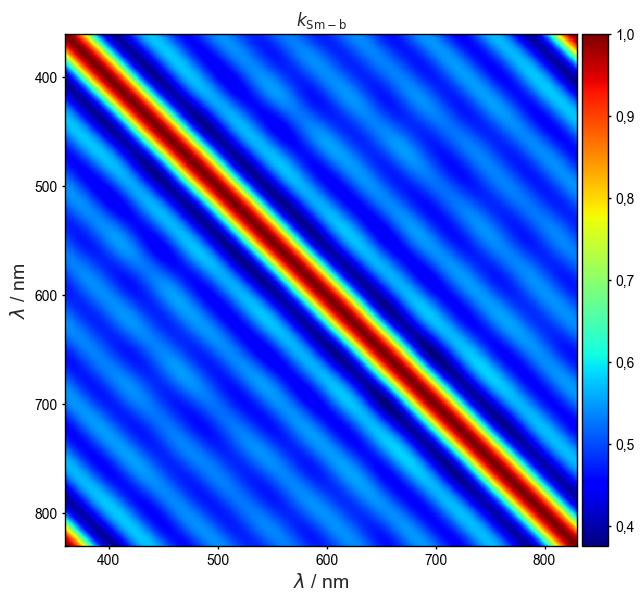

In [17]:
input1 = [mcT, mcLambda_a_c, mcLambda_a_uc, mcLambda_a_f, mcLambda_m_c, mcS_a_c, mcS_a_uc, mcS_a_f, mcS_m_f1]
output1 = [mcYxy, mcCCT, mcSMCF, mcSpectrum]
mcResult1, res_data1 = runSimpleMC(input1, output1, NumberTrials, model_L0)
corrDiag(mcResult1, 8, 1)

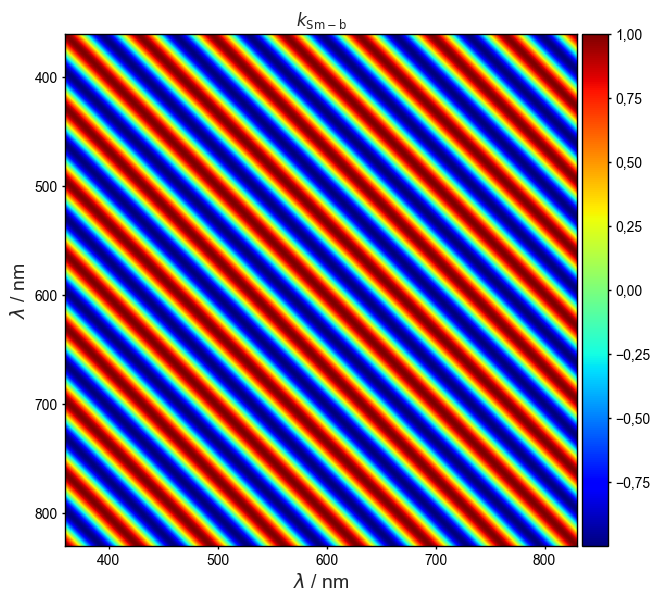

In [18]:
input2 = [mcT, mcLambda_a_c, mcLambda_a_uc, mcLambda_a_f, mcLambda_m_c, mcS_a_c, mcS_a_uc, mcS_a_f, mcS_m_f2]
output2 = [mcYxy, mcCCT, mcSMCF, mcSpectrum]
mcResult2, res_data2 = runSimpleMC(input2, output2, NumberTrials, model_L0)
corrDiag(mcResult2, 8, 2)

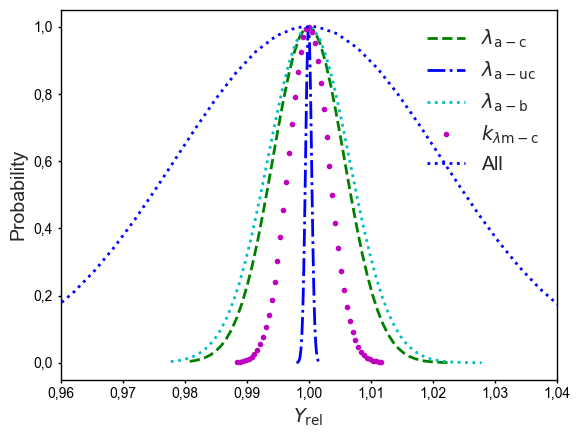

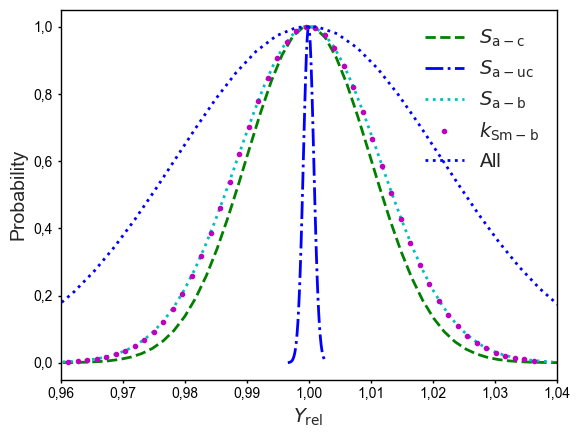

In [19]:
#display some histograms
ax1 = None
for i in [*range(1, len_part1), index_end]:
    var = mcResult[i]
    if ax1 is None:
        ax1 = plotHistGauss( var[0].val[:,0]/np.mean(var[0].val[:,0]), title=get_name(i), xLabel='$Y_{\mathrm{rel}}$', color=mColor[i]+marker[i], relative=True, fontsize=label_font_size)
    else:
        plotHistGauss( var[0].val[:,0]/np.mean(var[0].val[:,0]), title=get_name(i), xLabel='$Y_{\mathrm{rel}}$', ax=ax1, color=mColor[i]+marker[i], relative=True, fontsize=label_font_size)
pyplot.xlim([0.96,1.04])
pyplot.title('')
save_fig(out_dir, 'HistYxy_Yrel_Lambda')

ax1 = None
for i in range(len_part1, index_end+1):
    var = mcResult[i]
    if i == index_end:
        ii = i
    else:
        ii = i -len_part1+1
    if ax1 is None:
        ax1 = plotHistGauss( var[0].val[:,0]/np.mean(var[0].val[:,0]), title=get_name(i), xLabel='$Y_{\mathrm{rel}}$', color=mColor[ii]+marker[ii], relative=True, fontsize=label_font_size)
    else:
        plotHistGauss( var[0].val[:,0]/np.mean(var[0].val[:,0]), title=get_name(i), xLabel='$Y_{\mathrm{rel}}$', ax=ax1, color=mColor[ii]+marker[ii], relative=True, fontsize=label_font_size)
pyplot.xlim([0.96,1.04])
pyplot.title('')
save_fig(out_dir, 'HistYxy_Yrel_S')


Value= [1.0, 0.0026788692661893067] Inteval(95%)= 0.010553821295844923 U= 0.0052769106479224615


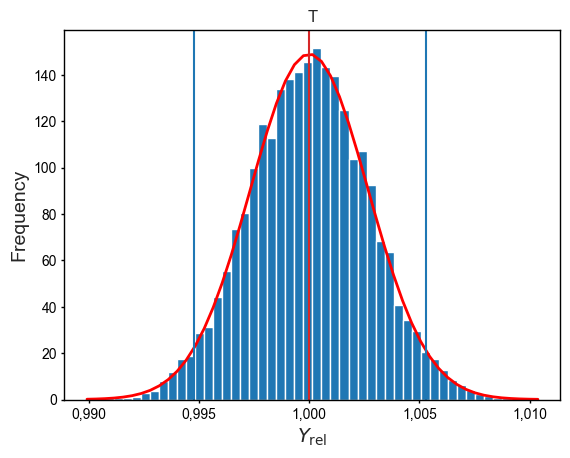

Value= [1.0, 0.00576876670301457] Inteval(95%)= 0.022490633861000364 U= 0.011245316930500182


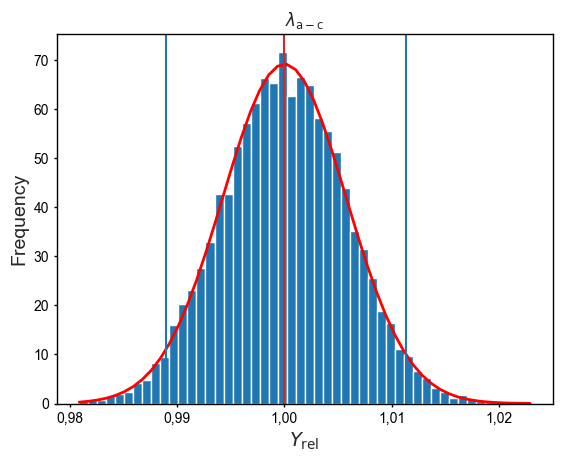

Value= [1.0, 0.0004845260626780542] Inteval(95%)= 0.0018833678263903142 U= 0.0009416839131951571


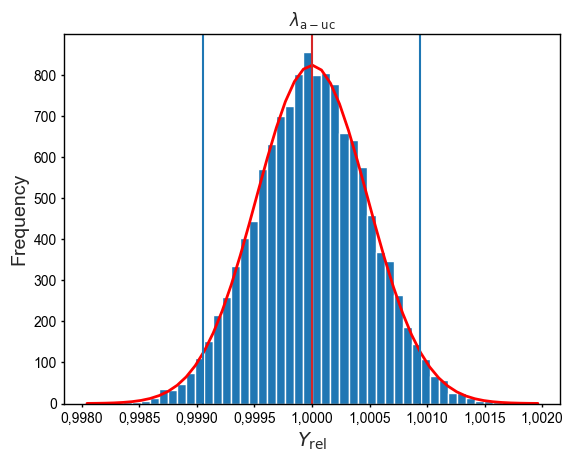

Value= [1.0, 0.00657898695999722] Inteval(95%)= 0.02534566143956396 U= 0.01267283071978198


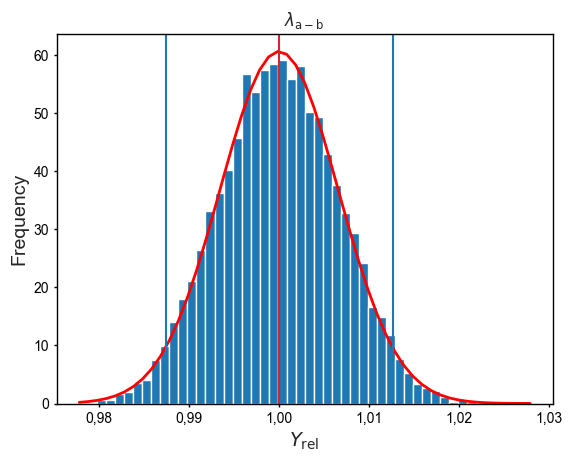

Value= [0.9999999999999998, 0.003248532494763097] Inteval(95%)= 0.012799611575764924 U= 0.006399805787882462


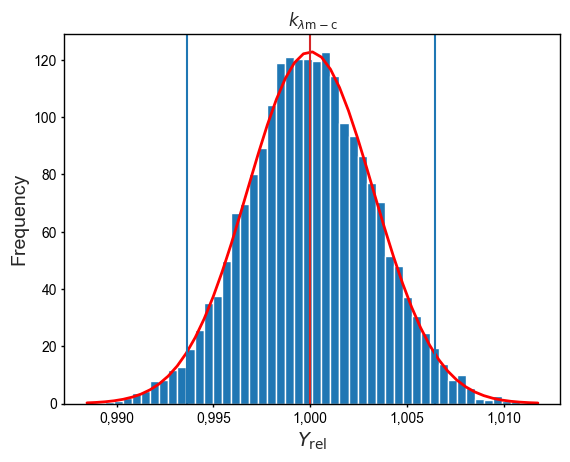

Value= [1.0, 0.010020691995204086] Inteval(95%)= 0.03924974052180197 U= 0.019624870260900984


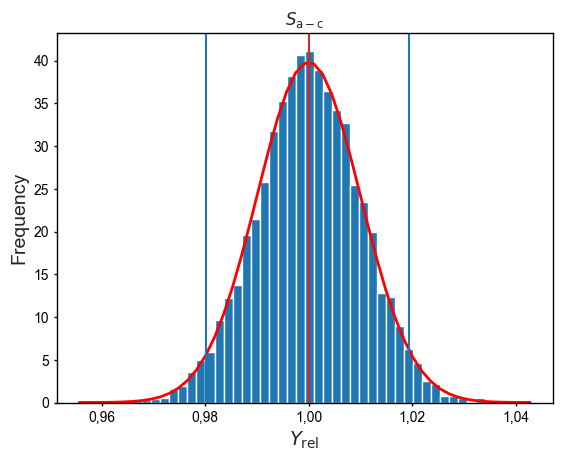

Value= [0.9999999999999998, 0.000836587168359488] Inteval(95%)= 0.00331390279642918 U= 0.00165695139821459


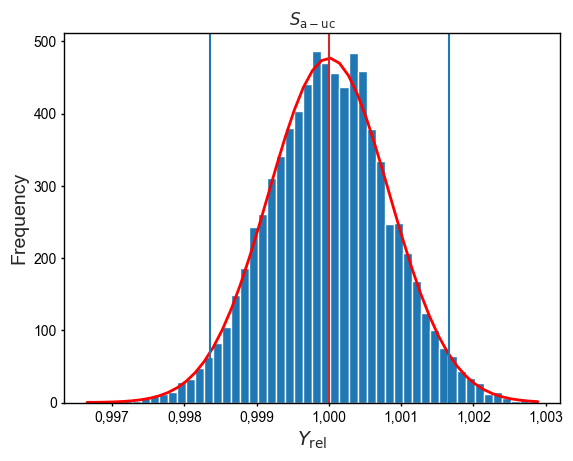

Value= [1.0, 0.011457244390260773] Inteval(95%)= 0.04419272739208746 U= 0.02209636369604373


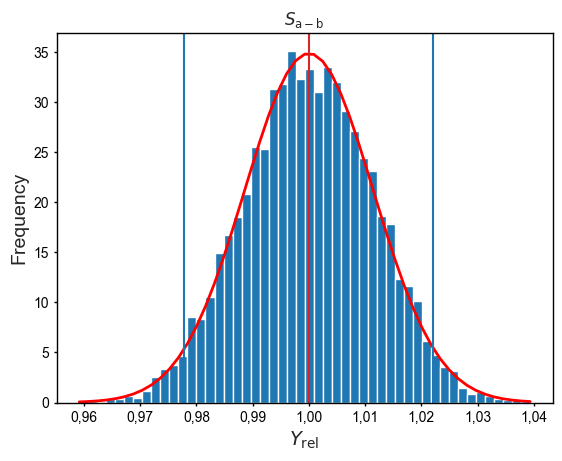

Value= [1.0, 0.011414201730160407] Inteval(95%)= 0.04378616400098145 U= 0.021893082000490727


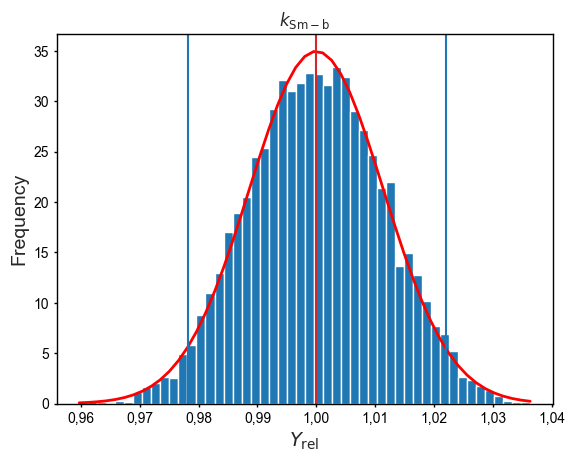

Value= [1.0, 0.021430397818633286] Inteval(95%)= 0.08344984845469217 U= 0.04172492422734608


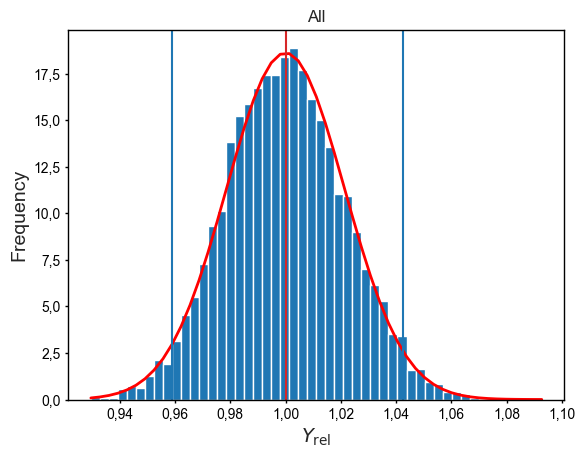

In [20]:
#display some histograms
for i in range(input_len+1):
    var = mcResult[i]
    plotHistScales( var[0].val[:,0]/np.mean(var[0].val[:,0]), add_distribution=True, title=get_name(i), xLabel='$Y_{\mathrm{rel}}$', fontsize=label_font_size, density=True)
    pyplot.ylabel('Frequency', fontsize=label_font_size)
    save_fig(out_dir, 'HistYxy_Lrel_'+str(i))

In [21]:
var = mcResult[0]
column_str_MC= [var[0].name.get_name_unit(0)[0], var[0].name.get_name_unit(1)[0], var[0].name.get_name_unit(2)[0],
                var[1].name.get_name_unit()[0], var[2].name.get_name_unit()[0]]
for i in range(input_len+1):
    var = mcResult[i]
    cct = mcResult[i][1]
    smcf = mcResult[i][2]
    print('Input_Var:', get_name(i))
    norm_data = pd.concat([pd.DataFrame(var[0].val[:,0]/np.mean(var[0].val[:,0])), pd.DataFrame(var[0].val[:,1]), pd.DataFrame(var[0].val[:,2]), pd.DataFrame(cct.val), pd.DataFrame(smcf.val)], axis=1)
    norm_data.columns = column_str_MC
    print( norm_data.corr())

Input_Var: T
              L           x           y         CCT           F
L    1.00000000 -0.99999844 -0.99999938  0.99999898  0.99999817
x   -0.99999844  1.00000000  0.99999979 -0.99999994 -0.99999999
y   -0.99999938  0.99999979  1.00000000 -0.99999995 -0.99999968
CCT  0.99999898 -0.99999994 -0.99999995  1.00000000  0.99999988
F    0.99999817 -0.99999999 -0.99999968  0.99999988  1.00000000
Input_Var: $\lambda_\mathrm{a-c}$
              L           x           y         CCT           F
L    1.00000000 -0.99999511 -0.99999950  0.99999997  0.99999326
x   -0.99999511  1.00000000  0.99999147 -0.99999588 -0.99999985
y   -0.99999950  0.99999147  1.00000000 -0.99999921 -0.99998906
CCT  0.99999997 -0.99999588 -0.99999921  1.00000000  0.99999416
F    0.99999326 -0.99999985 -0.99998906  0.99999416  1.00000000
Input_Var: $\lambda_\mathrm{a-uc}$
              L           x           y         CCT           F
L    1.00000000 -0.14016587  0.43767871  0.38360973  0.28151283
x   -0.14016587  1.000

Input_Var: T
Input_Var: $\lambda_\mathrm{a-c}$
Input_Var: $\lambda_\mathrm{a-uc}$
Input_Var: $\lambda_\mathrm{a-b}$
Input_Var: $k_{\lambda\mathrm{m-c}}$
Input_Var: $S_\mathrm{a-c}$
Input_Var: $S_\mathrm{a-uc}$
Input_Var: $S_\mathrm{a-b}$
Input_Var: $k_\mathrm{Sm-b}$
Input_Var: All


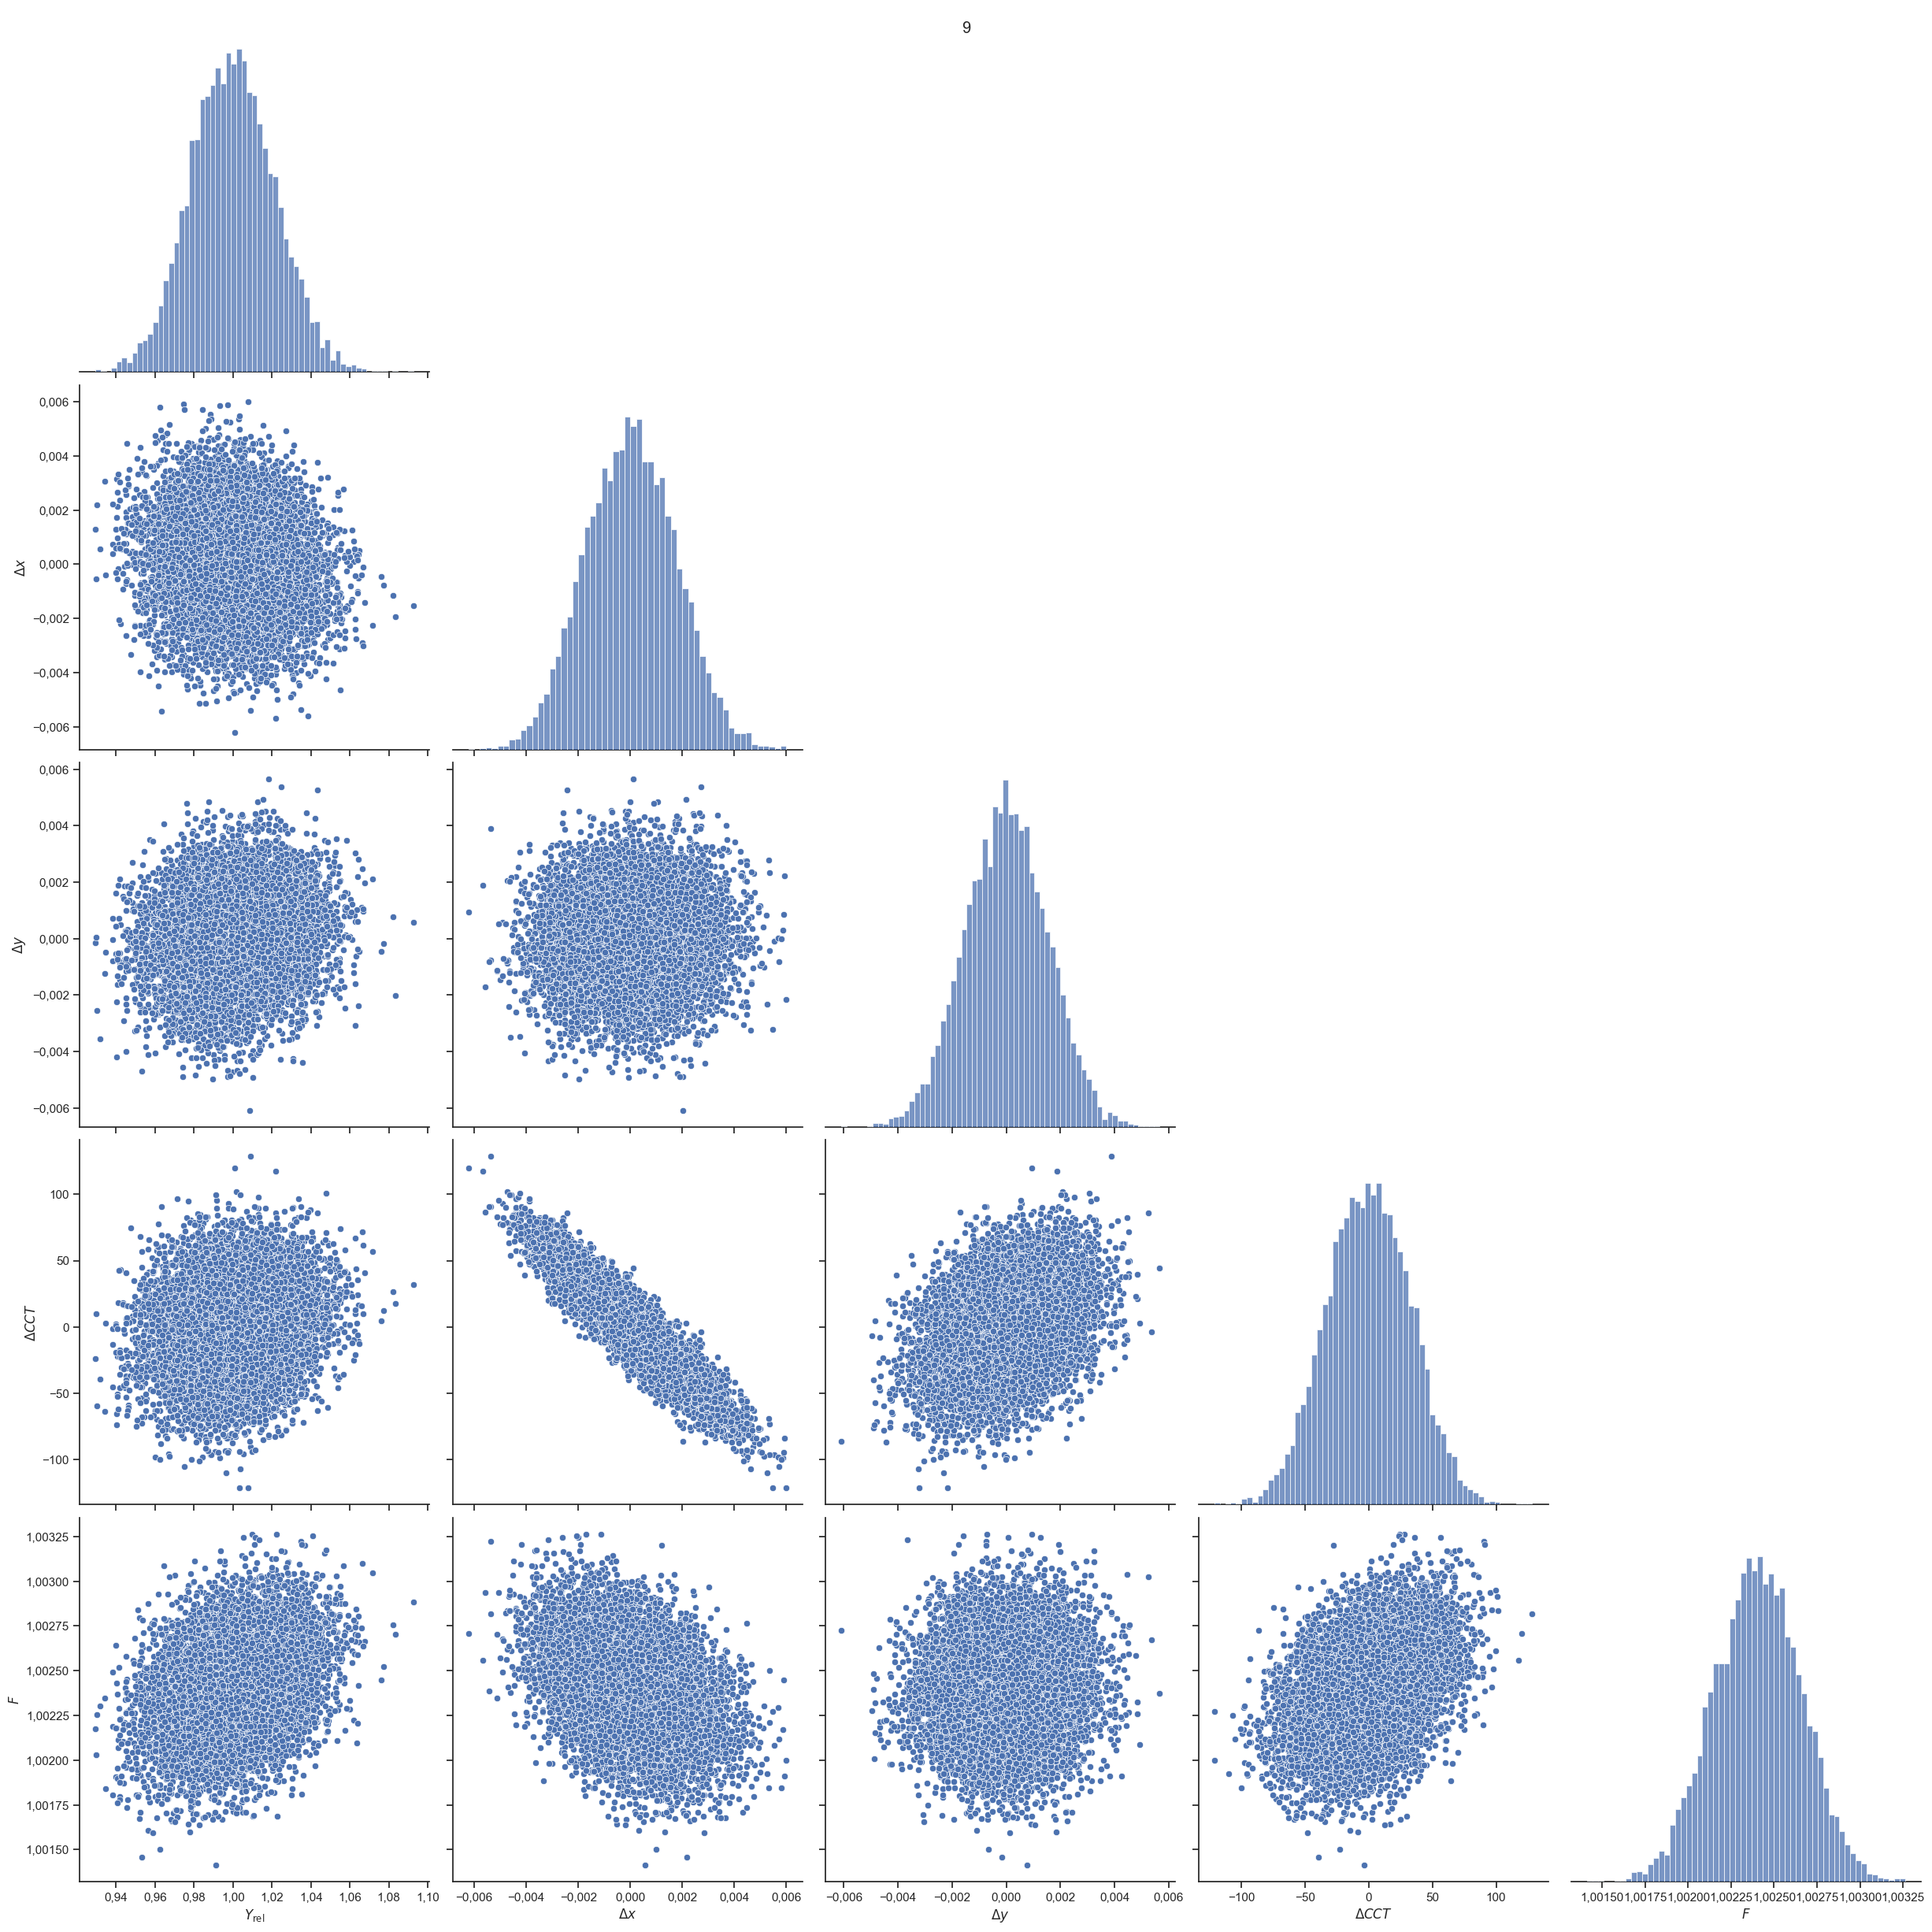

In [22]:
column_str_MC2= ['Y', var[0].name.get_name_unit(1)[0], var[0].name.get_name_unit(2)[0],
                var[1].name.get_name_unit()[0], var[2].name.get_name_unit()[0]]

for i in range(input_len+1):
    var = mcResult[i]
    cct = mcResult[i][1]
    smcf = mcResult[i][2]
    print('Input_Var:', get_name(i))
    if i==9:
        seaborn_plot_result_gen(np.vstack((var[0].val.T, cct.val.T, smcf.val.T)), display=['r','d','d','d','n'], dim=5, column_str=column_str_MC2, title=str(i))
        save_fig(out_dir, 'Observation_YxyCCTDuv_' + str(i))

# Ende part 1

# Evaluattion the influence of the basefunctions

In [23]:
# run the MCS for different base function settings

mcResultList = []
str_observe = 'CCT'
index_observe = 0
observed_value = []
observed_uvalue = []
#mcResult, res_data = runSimpleMC(mcT, mcLambda_a_c, mcLambda_a_uc, mcLambda_a_f, mcLambda_m_c, mcS_a_c, mcS_a_uc, mcS_a_f, mcS_m_f, mcYxy, mcCCT, mcSMCF, mcSpectrum, NumberTrials, model_L0)
mcResult_db_merge = None
# base funcktion fourier and chebychev
output = [mcYxy, mcCCT, mcSMCF, mcSpectrum]
for base_function in ['f', 'c']:
    # sum of all functions or a single base function only
    for single_funktion in [' ', 's']:
        # use a list of base funkction numbrs
        for index, petriNumber in enumerate(elements2Run):
            addParamString = base_function + ' ' + str(petriNumber) + ' ' + single_funktion + ' o'
            print ( f'BaseFunkction: {base_function}, Single: {single_funktion}, Simulation number : {index}, PetriNumber: {petriNumber}, String: {addParamString}')
            if petriNumber == -1:
                # use the original calibration data (FEL, Photoelement from PTB)
                mcResult, mcResult_db = runSimpleMC( inputFEL, output, NumberTrials, model_FEL)
                index_observe = 0
            else:
                # the basic versions of FEL and Photometer do not use the correlation information (only value and standard deviation)
                mcS_m_f_t = MCVectorVar(name=NameUnit('$k_\mathrm{Sm-b}$', ''), elements=len(wl), noise_list={ 'f_mul': DistributionParam(mean=1, stddev=0.01, add_params=addParamString)})
                mcS_m_f_t.set_vector_param( np.ones(len(wl)), 0.01*np.ones(len(wl)))
                input = [mcT, mcLambda_a_c, mcLambda_a_uc, mcLambda_a_f, mcLambda_m_c, mcS_a_c, mcS_a_uc, mcS_a_f, mcS_m_f_t]
                mcResult, mcResult_db = runSimpleMC( input, output, NumberTrials, model_L0)
                index_observe = 8

            print ( f"{str_observe}: {mcResult_db[str_observe].iloc[index_observe]:.8f} | u({str_observe}): {mcResult_db['u('+str_observe + ')'].iloc[index_observe]:.8f}")
            mcResultList.append(mcResult)

            mcResult_db = mcResult_db.assign(TRIALS=NumberTrials)
            mcResult_db = mcResult_db.assign(BASE=base_function)
            mcResult_db = mcResult_db.assign(E2R=petriNumber)
            mcResult_db = mcResult_db.assign(SINGLE=single_funktion)

            temp_cols=mcResult_db.columns.tolist()
            new_cols=temp_cols[-4:] + temp_cols[:-4]
            mcResult_db = mcResult_db[new_cols]

            if mcResult_db_merge is None:
                mcResult_db_merge = mcResult_db.copy()
            else:
                mcResult_db_merge = pd.concat([mcResult_db_merge, mcResult_db])

BaseFunkction: f, Single:  , Simulation number : 0, PetriNumber: -1, String: f -1   o
CCT: 3075.29565001 | u(CCT): 2.92374555
BaseFunkction: f, Single:  , Simulation number : 1, PetriNumber: 0, String: f 0   o
CCT: 3077.00000000 | u(CCT): 0.00000000
BaseFunkction: f, Single:  , Simulation number : 2, PetriNumber: 1, String: f 1   o
CCT: 3076.97570736 | u(CCT): 16.66001474
BaseFunkction: f, Single:  , Simulation number : 3, PetriNumber: 2, String: f 2   o
CCT: 3076.50690826 | u(CCT): 21.50936588
BaseFunkction: f, Single:  , Simulation number : 4, PetriNumber: 3, String: f 3   o
CCT: 3077.29800952 | u(CCT): 21.35454182
BaseFunkction: f, Single:  , Simulation number : 5, PetriNumber: 4, String: f 4   o
CCT: 3076.77683887 | u(CCT): 20.06765259
BaseFunkction: f, Single:  , Simulation number : 6, PetriNumber: 5, String: f 5   o
CCT: 3077.06212622 | u(CCT): 18.47255939
BaseFunkction: f, Single:  , Simulation number : 7, PetriNumber: 6, String: f 6   o
CCT: 3077.00046236 | u(CCT): 17.15585290


In [24]:
mcResult_db_merge

TRIALS BASE  E2R SINGLE                    Input    Unit           Mean   
0    10000    f   -1                         Input#0  Unit#0     0.05002378  \
0    10000    f   -1                             All             0.00000000   
0    10000    f    0                               T       K 3,077.00000000   
0    10000    f    0          $\lambda_\mathrm{a-c}$      nm     0.00000000   
0    10000    f    0         $\lambda_\mathrm{a-uc}$      nm     0.00000000   
..     ...  ...  ...    ...                      ...     ...            ...   
0    10000    c  235      s         $S_\mathrm{a-c}$             0.00000000   
0    10000    c  235      s        $S_\mathrm{a-uc}$             0.00000000   
0    10000    c  235      s         $S_\mathrm{a-b}$             0.00000000   
0    10000    c  235      s        $k_\mathrm{Sm-b}$             1.00000000   
0    10000    c  235      s                      All             0.00000000   

       StdDev             Distr          L       u(L)          x       u(x)   
0  0.00022769            normal 1.00000585 0.00453591 0.43183072 0.00015967  \
0  0.00000000                   1.00000585 0.00453591 0.43183072 0.00015967   
0  1.00000000            normal 1.00002117 0.00267623 0.43155443 0.00006851   
0  1.00000000            normal 1.00002223 0.00574108 0.43155397 0.00055553   
0  1.00000000            normal 1.00000334 0.00048672 0.43155371 0.00009851   
..        ...               ...        ...        ...        ...        ...   
0  0.01000000            normal 0.99984336 0.01005831 0.43155489 0.00000000   
0  0.01000000            normal 0.99999585 0.00083477 0.43155452 0.00014618   
0  0.01000000        normal c 7 1.00002862 0.01140549 0.43155363 0.00097303   
0  0.01000000  normal c 235 s o 1.00000000 0.00000001 0.43155489 0.00000001   
0  0.00000000                   0.99993173 0.01801118 0.43154401 0.00143612   

            y       u(y)            CCT      u(CCT)          F       u(F)  
0  0.40253870 0.00009614 3,075.29565001  2.92374555 1.00242212 0.00001879  
0  0.40253870 0.00009614 3,075.29565001  2.92374555 1.00242212 0.00001879  
0  0.40215523 0.00002538 3,077.00688424  0.99895379 1.00240360 0.00000999  
0  0.40215425 0.00025299 3,077.02845889  7.71053253 1.00240363 0.00007382  
0  0.40215341 0.00011608 3,077.00479729  1.71323514 1.00240370 0.00002306  
..        ...        ...            ...         ...        ...        ...  
0  0.40215541 0.00000000 3,077.00000000  0.00000000 1.00240353 0.00000000  
0  0.40215588 0.00013601 3,077.01160711  2.96744383 1.00240354 0.00003771  
0  0.40216012 0.00088741 3,077.11503167 20.05241099 1.00240349 0.00015153  
0  0.40215541 0.00000002 3,076.99999941  0.00008574 1.00240353 0.00000001  
0  0.40215372 0.00123378 3,077.30149032 26.15888875 1.00240522 0.00020718  

[1048 rows x 19 columns]

In [25]:
strDataBase = out_dir + '/database.csv'
strDataBase_k = out_dir + '/database_k.csv'

mcResult_db_merge.to_csv(strDataBase, index=False, sep=';', decimal='.', float_format='%.5f', mode='w')
mcResult_db_merge.to_csv(strDataBase_k, index=False, sep=';', decimal=',', float_format='%.5f', mode='w')

In [26]:
use_short = 1
# Run the very first and second cell and start with use_short = 1 here in the case you will skip the simulation
if use_short:
    strDataBase = out_dir + '/database.csv'
    mcResult_db_merge = pd.read_csv(strDataBase, sep=';', decimal='.')

L


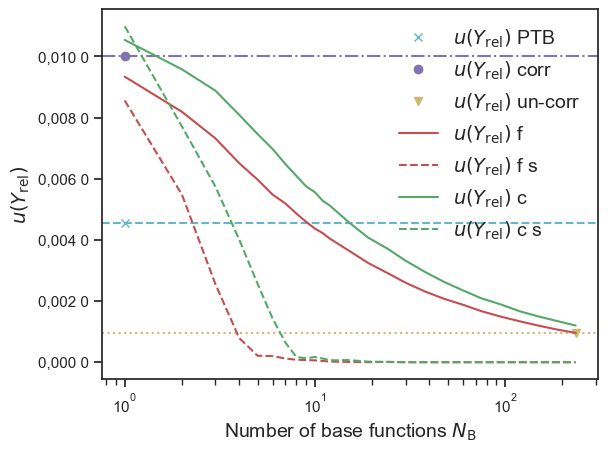

x


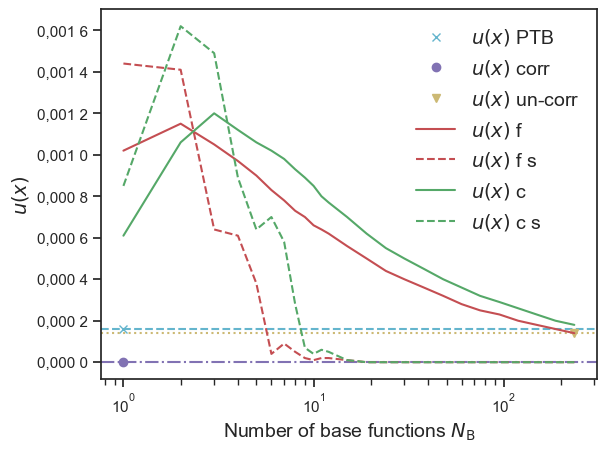

y


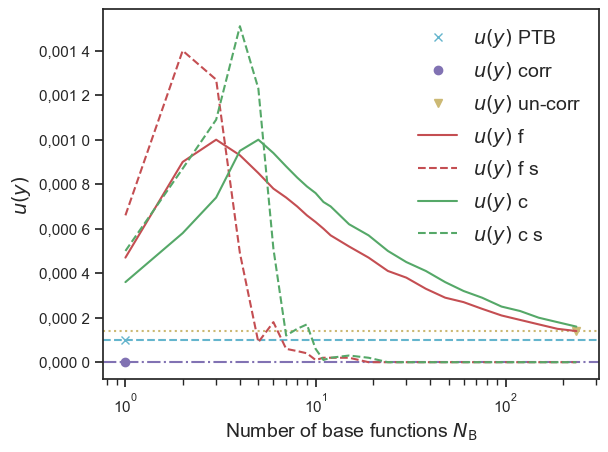

CCT


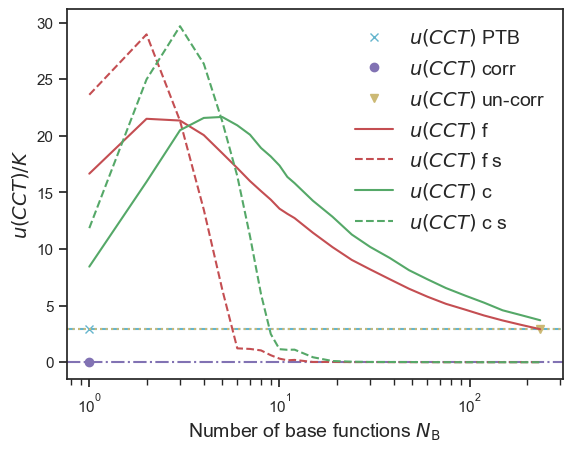

F


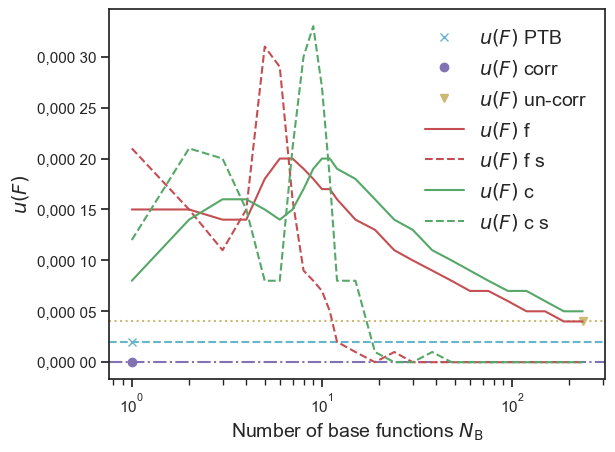

In [27]:
str_observe_list = ['L', 'x', 'y', 'CCT', 'F']
str_observe_unit = ['', '', '', 'K', '']
str_observe_listP = ['Y_\mathrm{rel}', 'x', 'y', 'CCT', 'F']

# to be moved to plotting ...
marker = ['-', '--', '-.',':']
point_marker = ['x', 'o', 'v', '^']
mColor = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w']

for str_observe in str_observe_list:
    list_index = str_observe_list.index(str_observe)
    str_observeP = str_observe_listP[list_index]
    fig, ax = pyplot.subplots()
    ii = 0
    for base_function in ['f', 'c']:
        iii=0
        for single_function in [' ', 's']:
            observed_value = []
            observed_uvalue = []
            dfq = []
            for index in range(len(elements2Run)):
                element = elements2Run[index]
                if element == -1:
                    dfq = mcResult_db_merge.query("Input=='Input#0'")
                    index_observe = 0
                else:
                    dfq = mcResult_db_merge.query("E2R==@element and BASE==@base_function and SINGLE==@single_function")
                    index_observe = 8
                observed_value.append(dfq[str_observe].iloc[index_observe])
                observed_uvalue.append(dfq['u(' + str_observe + ')'].iloc[index_observe])
            if ii==0 and iii==0:
                ax.plot(1, observed_uvalue[0], mColor[3]+point_marker[ii], label='$u(' + str_observeP + ')$' + ' PTB')
                ax.axhline(observed_uvalue[0], color = mColor[3], linestyle='--')
                ax.plot(1, observed_uvalue[1], mColor[4]+point_marker[ii+1], label='$u(' + str_observeP + ')$' + ' corr')
                ax.axhline(observed_uvalue[1], color = mColor[4], linestyle='-.')
                ax.plot(elements2Run[-1], observed_uvalue[-1], mColor[5]+point_marker[ii+2], label='$u(' + str_observeP + ')$' + ' un-corr')
                ax.axhline(observed_uvalue[-1], color = mColor[5], linestyle=':')

            ax.plot(elements2Run[2:], observed_uvalue[2:], mColor[ii]+marker[iii], label='$u(' + str_observeP + ')$' + ' ' + base_function + ' ' + single_function)
            iii+=1
        ii+=1
    ax.set_xscale('log')
    ax.set_xlabel(r"Number of base functions $N_\mathrm{B}$",fontsize=label_font_size)
    if str_observe == 'F':
        ax.set_ylabel('$u(' + str_observeP + ')$',fontsize=label_font_size)
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(custom_color1))
    else:
        if len(str_observe_unit[list_index]):
            ax.set_ylabel('$u(' + str_observeP + ') / ' + str_observe_unit[list_index] +'$',fontsize=label_font_size)
        else:
            ax.set_ylabel('$u(' + str_observeP + ')$',fontsize=label_font_size)
            ax.yaxis.set_major_formatter(ticker.FuncFormatter(custom_color))

    ax.legend(frameon=False,fontsize=label_font_size)
#    ax2 = ax.twiny()
#    new_tick_locations = range( len(elements2Run))
#    def tick_function(X):
#        return ["%d" % elements2Run[z] for z in X]
#    ax2.set_xlim((1,500))
#    ax2.set_xticks(new_tick_locations)
#    ax2.set_xticklabels(tick_function(new_tick_locations))
#    pyplot.tick_params(axis='both', labelrotation=90, labelsize=10)

#    ax2.set_xscale('log')
#    ax2.set_xticks(elements2Run[2::2])
#    ax2.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

    print( str_observe)
    save_fig(out_dir, 'base' + str_observe)

In [28]:
# Ende part 2

# LED Test

In [29]:
# run the MCS for different base function settings

mcResultList = []
str_observe = 'lpeak'
index_observe = 0
observed_value = []
observed_uvalue = []
#mcResult, res_data = runSimpleMC(mcT, mcLambda_a_c, mcLambda_a_uc, mcLambda_a_f, mcLambda_m_c, mcS_a_c, mcS_a_uc, mcS_a_f, mcS_m_f, mcYxy, mcCCT, mcSMCF, mcSpectrum, NumberTrials, model_L0)
mcResult_db_merge = None
# base funcktion fourier and chebychev
for base_function in ['f', 'c']:
    # sum of all functions or a single base function only
    for single_funktion in [' ', 's']:
        # use a list of base funkction numbrs
        for index, petriNumber in enumerate(elements2Run):
            addParamString = base_function + ' ' + str(petriNumber) + ' ' + single_funktion + ' o'
            print ( f'BaseFunkction: {base_function}, Single: {single_funktion}, Simulation number : {index}, PetriNumber: {petriNumber}, String: {addParamString}')
            output = [mcYxy, mclpeak, mcSMCF, mcSpectrum]
            if petriNumber == -1:
                inputLED = [mcLED, mcLambda_a_c, mcLambda_a_uc, mcLambda_a_f, mcLambda_m_c, mcS_a_c, mcS_a_uc, mcS_a_f, mcS_m_f]
                mcResult, mcResult_db = runSimpleMC(inputLED, output, NumberTrials, model_LED)
                index_observe = 0
            else:
                # the basic versions of FEL and Photometer do not use the correlation information (only value and standard deviation)
                mcS_m_f_t = MCVectorVar(name=NameUnit('$k_\mathrm{Sm-b}$', ''), elements=len(wl), noise_list={ 'f_mul': DistributionParam(mean=1, stddev=0.01, add_params=addParamString)})
                mcS_m_f_t.set_vector_param( np.ones(len(wl)), 0.01*np.ones(len(wl)))
                inputLED = [mcLED, mcLambda_a_c, mcLambda_a_uc, mcLambda_a_f, mcLambda_m_c, mcS_a_c, mcS_a_uc, mcS_a_f, mcS_m_f_t]
                mcResult, mcResult_db = runSimpleMC(inputLED, output, NumberTrials, model_LED)
                index_observe = 8

            print ( f"{str_observe}: {mcResult_db[str_observe].iloc[index_observe]:.8f} | u({str_observe}): {mcResult_db['u('+str_observe + ')'].iloc[index_observe]:.8f}")
            mcResultList.append(mcResult)

            mcResult_db = mcResult_db.assign(TRIALS=NumberTrials)
            mcResult_db = mcResult_db.assign(BASE=base_function)
            mcResult_db = mcResult_db.assign(E2R=petriNumber)
            mcResult_db = mcResult_db.assign(SINGLE=single_funktion)

            temp_cols=mcResult_db.columns.tolist()
            new_cols=temp_cols[-4:] + temp_cols[:-4]
            mcResult_db = mcResult_db[new_cols]

            if mcResult_db_merge is None:
                mcResult_db_merge = mcResult_db.copy()
            else:
                mcResult_db_merge = pd.concat([mcResult_db_merge, mcResult_db])

BaseFunkction: f, Single:  , Simulation number : 0, PetriNumber: -1, String: f -1   o
lpeak: 554.99590000 | u(lpeak): 1.04435779
BaseFunkction: f, Single:  , Simulation number : 1, PetriNumber: 0, String: f 0   o
lpeak: 555.00000000 | u(lpeak): 0.00000000
BaseFunkction: f, Single:  , Simulation number : 2, PetriNumber: 1, String: f 1   o
lpeak: 555.00000000 | u(lpeak): 0.00000000
BaseFunkction: f, Single:  , Simulation number : 3, PetriNumber: 2, String: f 2   o
lpeak: 555.00000000 | u(lpeak): 0.00000000
BaseFunkction: f, Single:  , Simulation number : 4, PetriNumber: 3, String: f 3   o
lpeak: 555.00000000 | u(lpeak): 0.00000000
BaseFunkction: f, Single:  , Simulation number : 5, PetriNumber: 4, String: f 4   o
lpeak: 555.00000000 | u(lpeak): 0.00000000
BaseFunkction: f, Single:  , Simulation number : 6, PetriNumber: 5, String: f 5   o
lpeak: 555.00000000 | u(lpeak): 0.00000000
BaseFunkction: f, Single:  , Simulation number : 7, PetriNumber: 6, String: f 6   o
lpeak: 555.00000000 | u(l

In [30]:
mcResult_db_merge

TRIALS BASE  E2R SINGLE                      Input Unit         Mean   
0    10000    f   -1                          led_peak   nm 555.00000000  \
0    10000    f   -1            $\lambda_\mathrm{a-c}$   nm   0.00000000   
0    10000    f   -1           $\lambda_\mathrm{a-uc}$   nm   0.00000000   
0    10000    f   -1            $\lambda_\mathrm{a-b}$   nm   0.00000000   
0    10000    f   -1         $k_{\lambda\mathrm{m-c}}$    1   1.00000000   
..     ...  ...  ...    ...                        ...  ...          ...   
0    10000    c  235      s           $S_\mathrm{a-c}$        0.00000000   
0    10000    c  235      s          $S_\mathrm{a-uc}$        0.00000000   
0    10000    c  235      s           $S_\mathrm{a-b}$        0.00000000   
0    10000    c  235      s          $k_\mathrm{Sm-b}$        1.00000000   
0    10000    c  235      s                        All        0.00000000   

       StdDev             Distr          L       u(L)          x       u(x)   
0  1.00000000            normal 0.99978324 0.00030572 0.34236850 0.00702423  \
0  1.00000000            normal 0.99978101 0.00031771 0.34233727 0.00706240   
0  1.00000000            normal 0.99988440 0.01512547 0.34241780 0.00110273   
0  1.00000000        normal c 7 0.99964718 0.03054118 0.34243370 0.00920315   
0  0.00100000            normal 0.99991872 0.00095807 0.34231162 0.00389704   
..        ...               ...        ...        ...        ...        ...   
0  0.01000000            normal 0.99999220 0.01007996 0.34237407 0.00000000   
0  0.01000000            normal 1.00001373 0.00184382 0.34237339 0.00007833   
0  0.01000000        normal c 7 1.00016391 0.01359533 0.34237345 0.00015734   
0  0.01000000  normal c 235 s o 1.00000000 0.00000001 0.34237407 0.00000000   
0  0.00000000                   0.99845690 0.03757157 0.34255293 0.01397608   

            y       u(y)        lpeak   u(lpeak)          F       u(F)  
0  0.65265225 0.00657545 554.99590000 1.04435779 1.00330105 0.00219376  
0  0.65268126 0.00661130 554.99970000 1.04895181 1.00331158 0.00220512  
0  0.65260670 0.00103760 554.99570000 1.01856836 1.00330047 0.00037112  
0  0.65257363 0.00861802 555.00830000 1.42703578 1.00334105 0.00290974  
0  0.65272055 0.00365190 554.98920000 0.62103411 1.00326812 0.00120321  
..        ...        ...          ...        ...        ...        ...  
0  0.65266849 0.00000000 555.00000000 0.00000000 1.00322633 0.00000000  
0  0.65266915 0.00007414 554.99630000 0.70475975 1.00322643 0.00002652  
0  0.65266905 0.00014768 555.00000000 0.00000000 1.00322657 0.00004879  
0  0.65266849 0.00000000 554.98140000 0.74488525 1.00322633 0.00000000  
0  0.65239479 0.01307774 555.00100000 2.38306504 1.00354540 0.00438154  

[1080 rows x 19 columns]

L


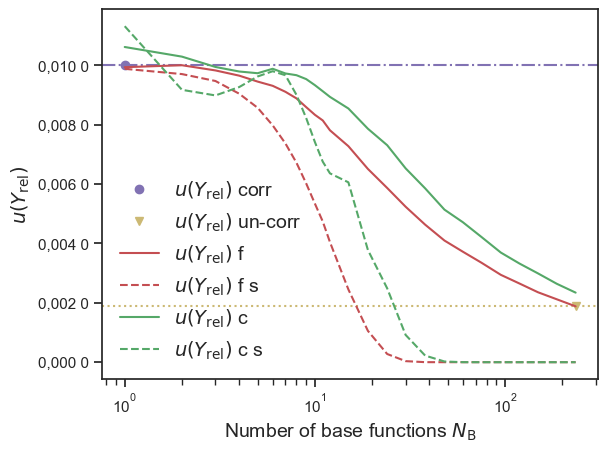

x


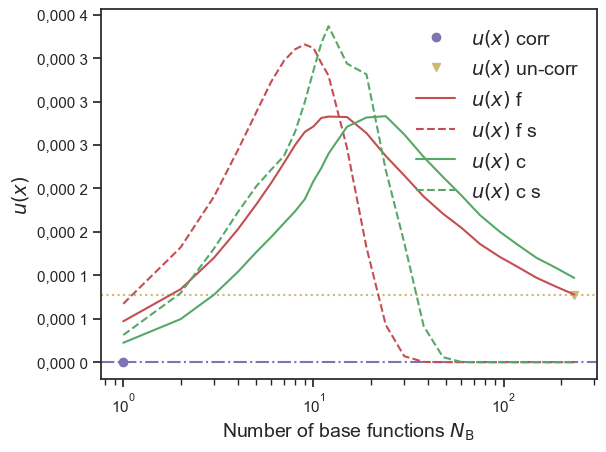

y


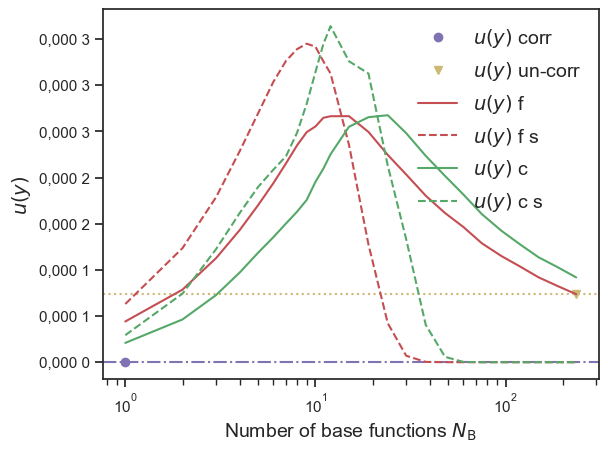

lpeak


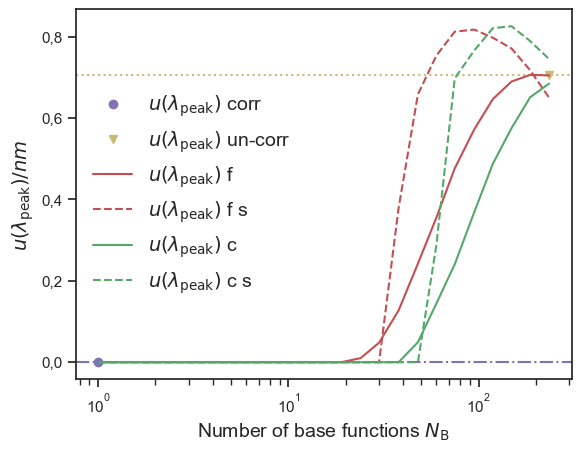

F


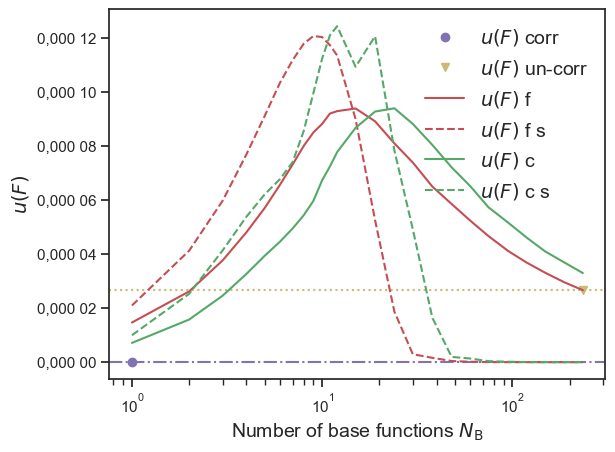

In [31]:
str_observe_list = ['L', 'x', 'y', 'lpeak', 'F']
str_observe_unit = ['', '', '', 'nm', '']
str_observe_listP = ['Y_\mathrm{rel}', 'x', 'y', '\lambda_{\mathrm{peak}}', 'F']

# to be moved to plotting ...
marker = ['-', '--', '-.',':']
point_marker = ['x', 'o', 'v', '^']
mColor = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w']

for str_observe in str_observe_list:
    list_index = str_observe_list.index(str_observe)
    str_observeP = str_observe_listP[list_index]
    fig, ax = pyplot.subplots()
    ii = 0
    for base_function in ['f', 'c']:
        iii=0
        for single_function in [' ', 's']:
            observed_value = []
            observed_uvalue = []
            dfq = []
            for index in range(len(elements2Run)):
                element = elements2Run[index]
                if element == -1:
                    dfq = mcResult_db_merge.query("E2R==@element")
                    index_observe = 0
                else:
                    dfq = mcResult_db_merge.query("E2R==@element and BASE==@base_function and SINGLE==@single_function")
                    index_observe = 8
                observed_value.append(dfq[str_observe].iloc[index_observe])
                observed_uvalue.append(dfq['u(' + str_observe + ')'].iloc[index_observe])
            if ii==0 and iii==0:
                #ax.plot(1, observed_uvalue[0], mColor[3]+point_marker[ii], label='$u(' + str_observeP + ')$' + ' PTB')
                #ax.axhline(observed_uvalue[0], color = mColor[3], linestyle='--')
                ax.plot(1, observed_uvalue[1], mColor[4]+point_marker[ii+1], label='$u(' + str_observeP + ')$' + ' corr')
                ax.axhline(observed_uvalue[1], color = mColor[4], linestyle='-.')
                ax.plot(elements2Run[-1], observed_uvalue[-1], mColor[5]+point_marker[ii+2], label='$u(' + str_observeP + ')$' + ' un-corr')
                ax.axhline(observed_uvalue[-1], color = mColor[5], linestyle=':')

            ax.plot(elements2Run[2:], observed_uvalue[2:], mColor[ii]+marker[iii], label='$u(' + str_observeP + ')$' + ' ' + base_function + ' ' + single_function)
            iii+=1
        ii+=1
    ax.set_xscale('log')
    ax.set_xlabel(r"Number of base functions $N_\mathrm{B}$",fontsize=label_font_size)
    if str_observe == 'F':
        ax.set_ylabel('$u(' + str_observeP + ')$',fontsize=label_font_size)
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(custom_color1))
    else:
        if len(str_observe_unit[list_index]):
            ax.set_ylabel('$u(' + str_observeP + ') / ' + str_observe_unit[list_index] +'$',fontsize=label_font_size)
        else:
            ax.set_ylabel('$u(' + str_observeP + ')$',fontsize=label_font_size)
            ax.yaxis.set_major_formatter(ticker.FuncFormatter(custom_color))

    ax.legend(frameon=False,fontsize=label_font_size)
#    ax2 = ax.twiny()
#    new_tick_locations = range( len(elements2Run))
#    def tick_function(X):
#        return ["%d" % elements2Run[z] for z in X]
#    ax2.set_xlim((1,500))
#    ax2.set_xticks(new_tick_locations)
#    ax2.set_xticklabels(tick_function(new_tick_locations))
#    pyplot.tick_params(axis='both', labelrotation=90, labelsize=10)

#    ax2.set_xscale('log')
#    ax2.set_xticks(elements2Run[2::2])
#    ax2.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

    print( str_observe)
    save_fig(out_dir, 'LEDbase' + str_observe)

In [32]:
# Ende Gelände